In [1]:
import meep as mp
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Video
from scipy.constants import pi, c
from scipy.signal import hilbert, find_peaks
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from matplotlib.ticker import FormatStrFormatter, FuncFormatter
import matplotlib


In [2]:
plt.rcParams['figure.figsize'] = [4,3]
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300

plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

In [3]:
#Define conversion functions/factors to get to/from meep units and kms
#Length factor to transform lengths in kms
l_unit = 1e-6 #1 um
t_unit = l_unit/c #time unit is length/c

#multiplicative constants to convert frequencies from meep to kms hertz
freq_unit = c/l_unit

print("1 meep Length unit is", l_unit*1e+6, "um")
print("1 meep Time unit is", t_unit*1e+15, "fs")
print("1 meep Frequency unit is", freq_unit*1e-12, "THz")

1 meep Length unit is 1.0 um
1 meep Time unit is 3.3356409519815204 fs
1 meep Frequency unit is 299.792458 THz


# Resolution

In [4]:
#courant factor
S = 0.5

#resolution is number of pixels per meep unit
resolution = 10

#resolutions in meep units
space_res = 1/resolution
time_res = space_res*S

print("Pixel per unit: ", resolution)

print("Space resolution [meep]: ", space_res)
print("Time resolution [meep]: ", time_res)

print("Space resolution [um]: ", space_res*l_unit*1e+6)
print("Time resolution [fs]: ", time_res*t_unit*1e+15)

time_freq = 1/time_res
print("Time sampling frequency [meep]: ", time_freq)
print("Nyqvist frequency [meep]: ", time_freq/2)

Pixel per unit:  10
Space resolution [meep]:  0.1
Time resolution [meep]:  0.05
Space resolution [um]:  0.09999999999999999
Time resolution [fs]:  0.16678204759907606
Time sampling frequency [meep]:  20.0
Nyqvist frequency [meep]:  10.0


# Geometry Definition
Cell

In [5]:
#define cell size and resolution
#Cell size is in meep units
#center is in (0,0), ranges in x=(-sx/2,sx/2), y=(-sy/2,sy/2)
sx = 90
sy = 32

cell = mp.Vector3(sx, sy)

#boundary conditions thickness
pml_thickness = 1.0

#automatic positioning of boundaries
x_bound_up = sx/2 - pml_thickness
x_bound_low = -sx/2 + pml_thickness

y_bound_up = sy/2 - pml_thickness
y_bound_low = -sy/2 + pml_thickness

In [6]:
# Fixed parameters

#materials refractive indexes
n_bgnd = 1
n_wvg = 3.55
n_ring = n_wvg

#Width properties
wvg_width = 1.6

ring_r = 7
ring_w = wvg_width

## Running parameters

In [7]:
distances = np.arange(0.1,1.15,0.05)
loop_f_central_resonance = []
loop_attenuation = []

# Resonance Search

Beginning Resonance search
###############
Beginning iteration:  0
Distance:  0.1
Resonance frequency:  0.048560200668896325
Resonance attenuation:  0.011716702171469324
###############
Beginning iteration:  1
Distance:  0.15000000000000002
Resonance frequency:  0.04851003344481605
Resonance attenuation:  0.0038044232867196336
###############
Beginning iteration:  2
Distance:  0.20000000000000004
Resonance frequency:  0.04844314381270903
Resonance attenuation:  0.047940004251209735
###############
Beginning iteration:  3
Distance:  0.25000000000000006
Resonance frequency:  0.04835953177257525
Resonance attenuation:  0.12226921014049248
###############
Beginning iteration:  4
Distance:  0.30000000000000004
Resonance frequency:  0.04829264214046823
Resonance attenuation:  0.21426469787928976
###############
Beginning iteration:  5
Distance:  0.3500000000000001
Resonance frequency:  0.04820903010033445
Resonance attenuation:  0.30438381889882804
###############
Beginning iteration:  6
Dis

/tmp/ipykernel_38414/2945638394.py:133: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


###############
Beginning iteration:  20
Distance:  1.1000000000000005
Resonance frequency:  0.04665384615384616
Resonance attenuation:  0.7326205776502895
[0.0485602  0.04851003 0.04844314 0.04835953 0.04829264 0.04820903
 0.0481087  0.04800836 0.04790803 0.04780769 0.04769064 0.0475903
 0.04747324 0.04737291 0.04725585 0.0471388  0.04703846 0.04693813
 0.04685452 0.04675418 0.04665385]


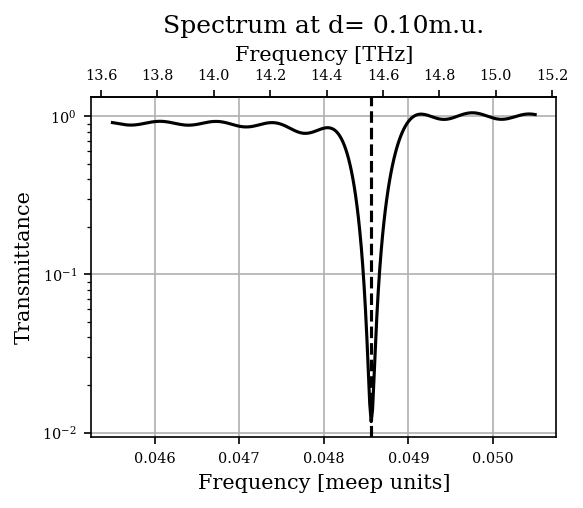

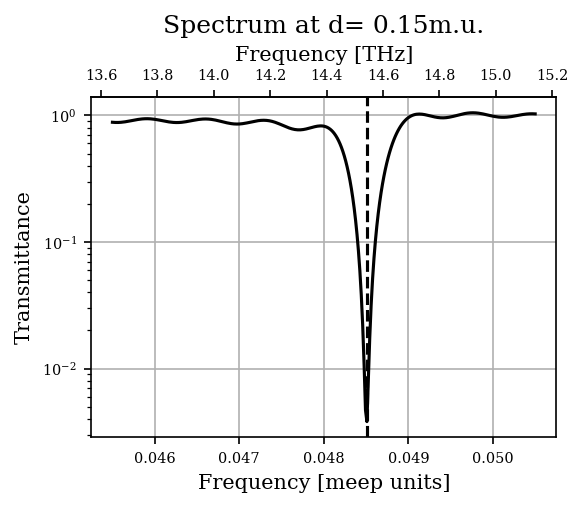

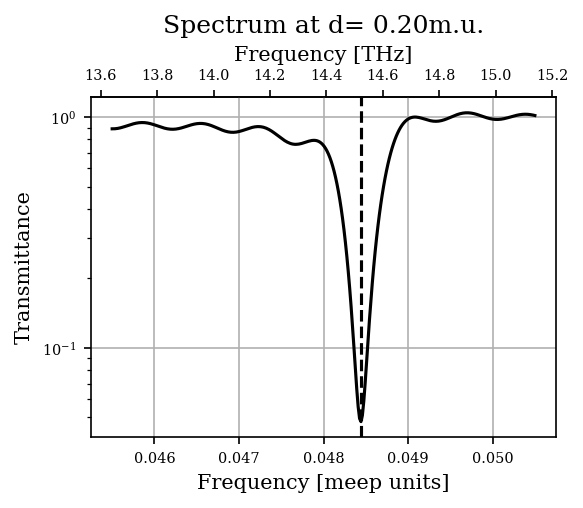

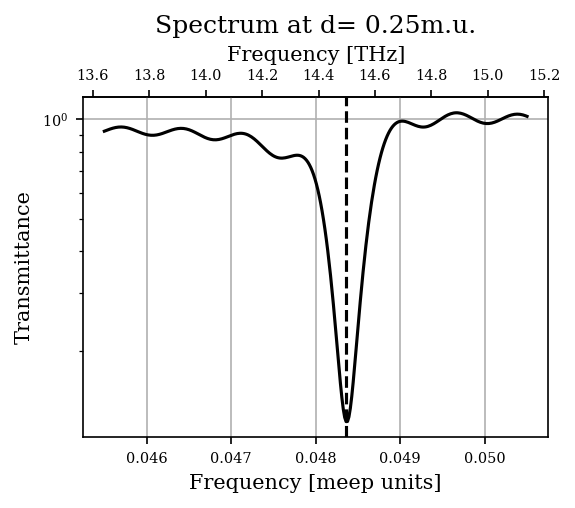

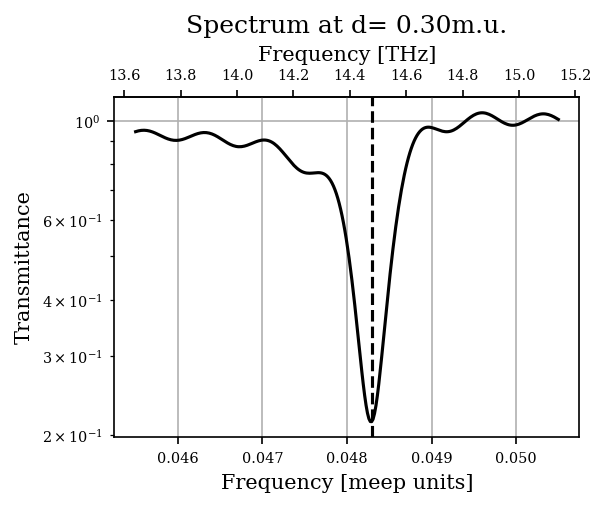

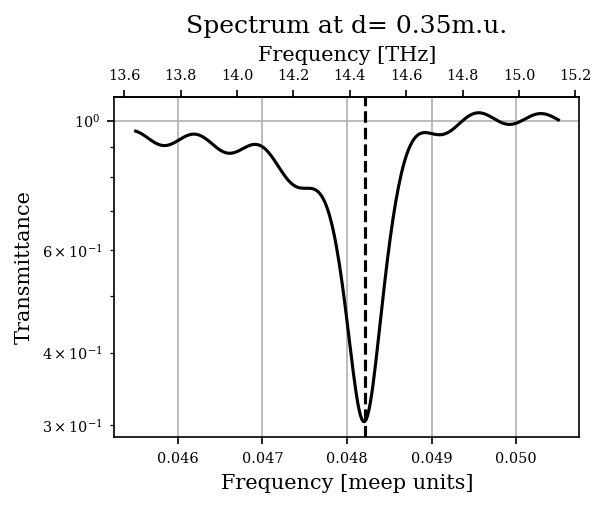

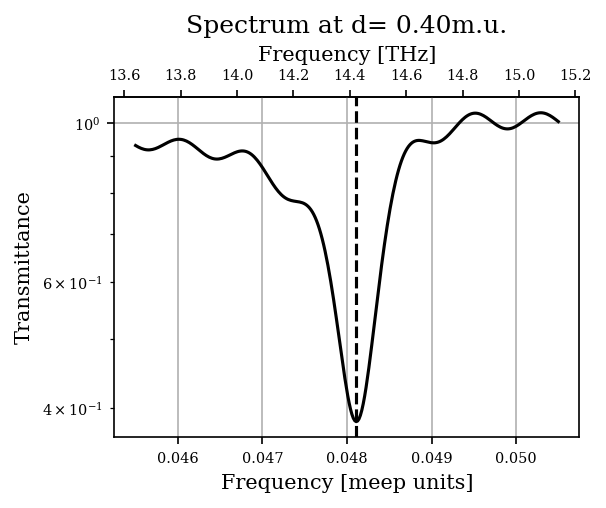

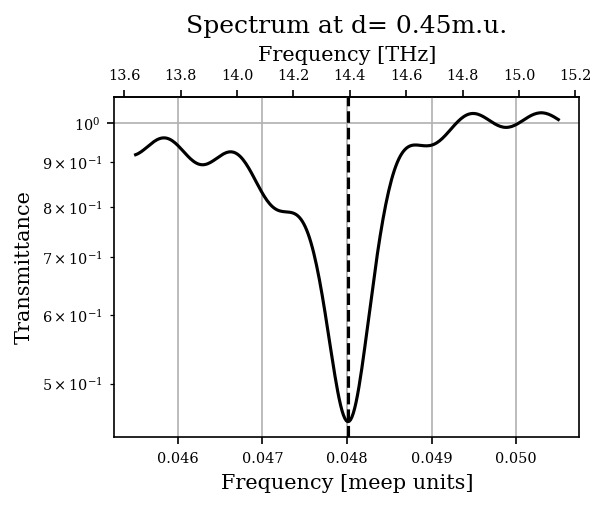

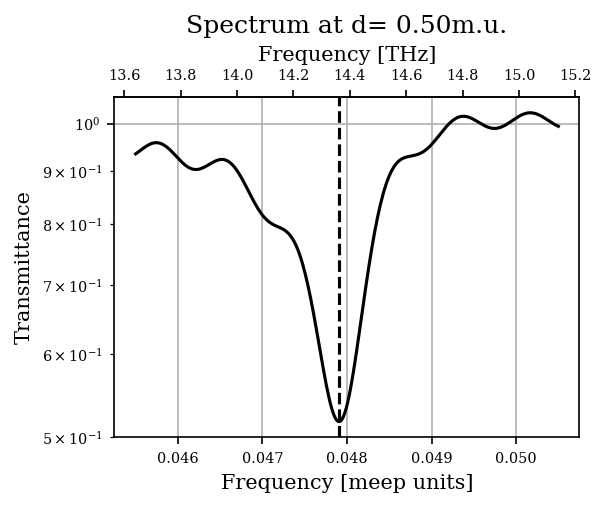

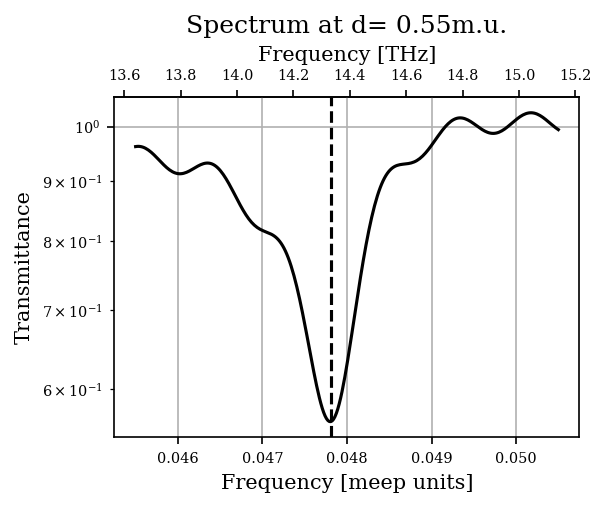

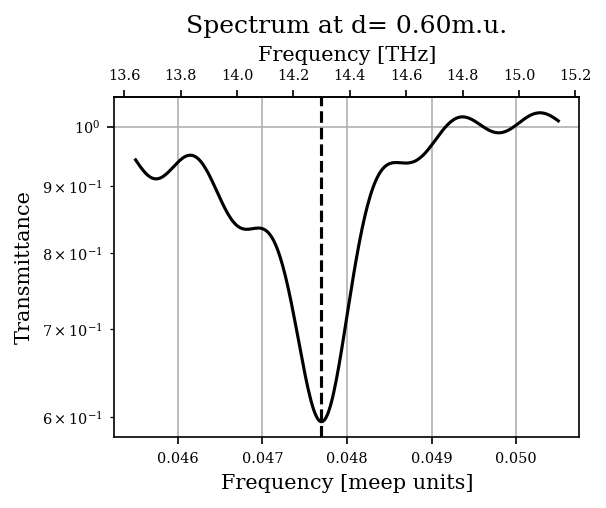

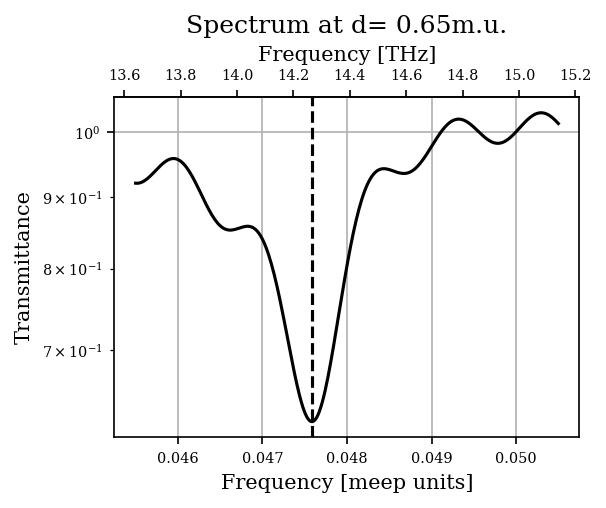

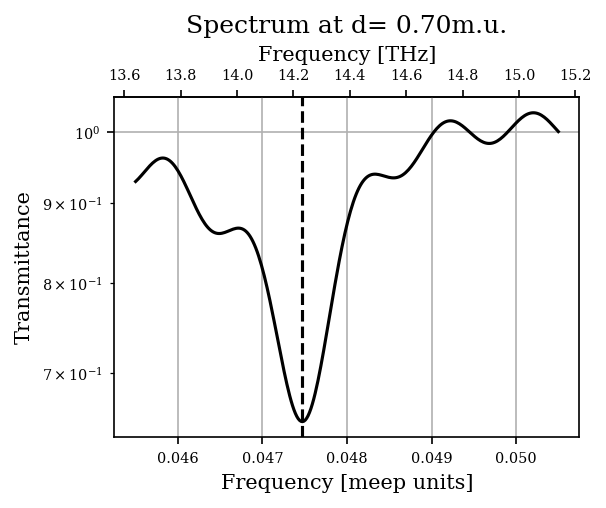

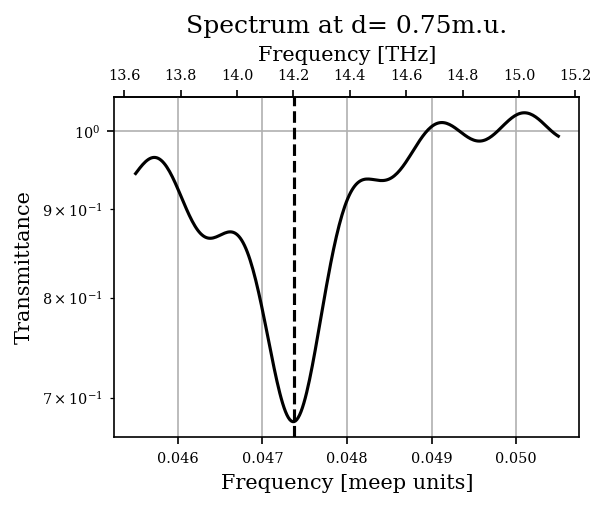

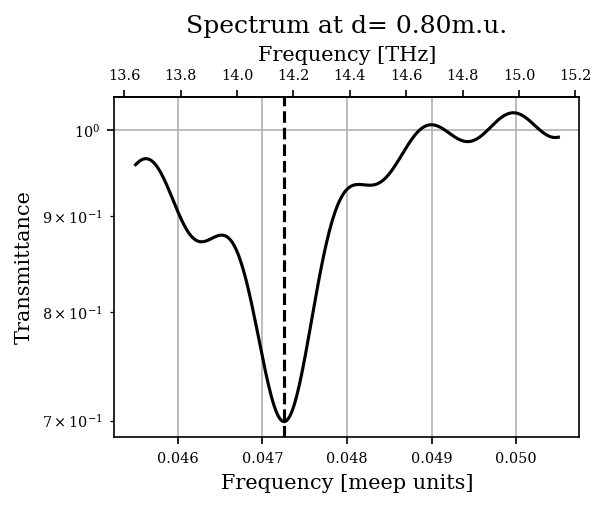

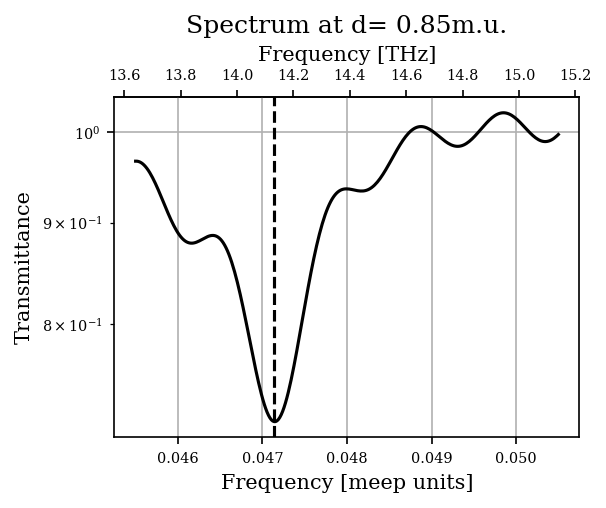

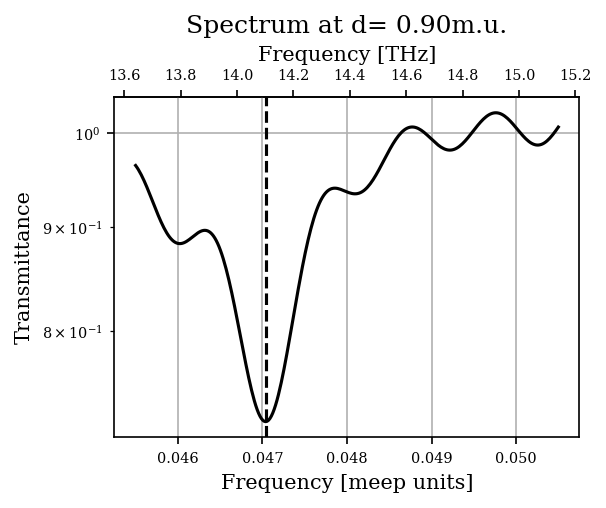

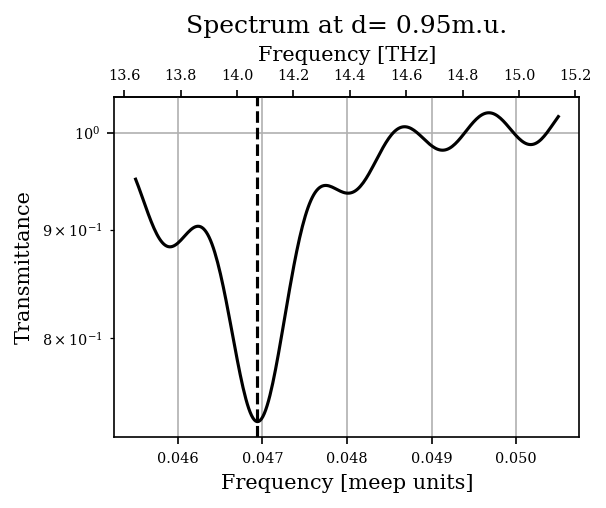

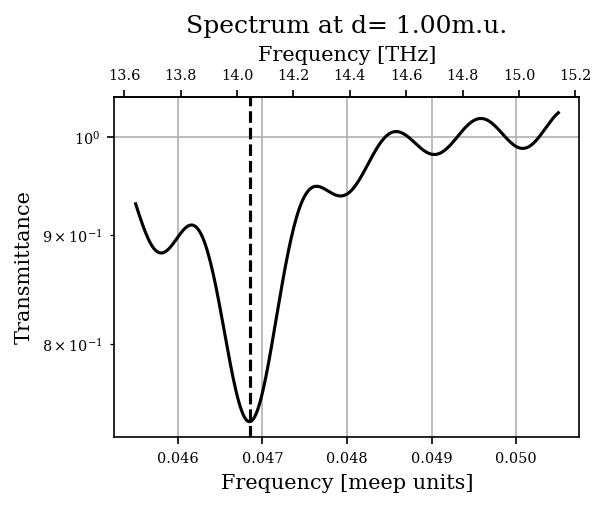

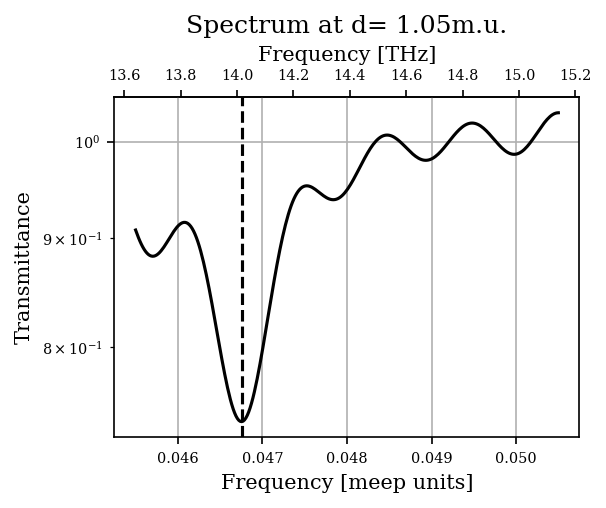

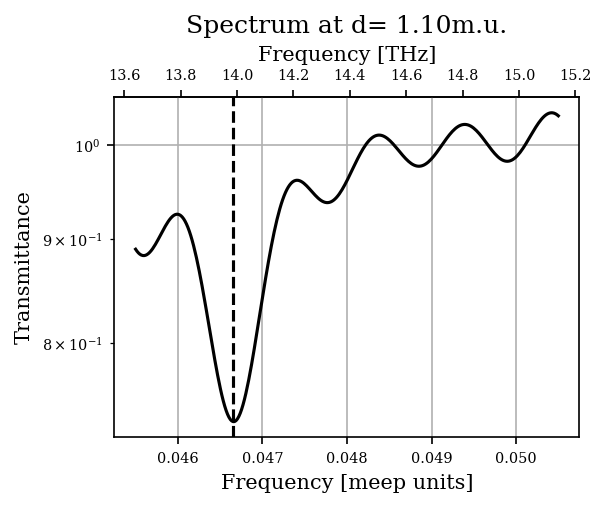

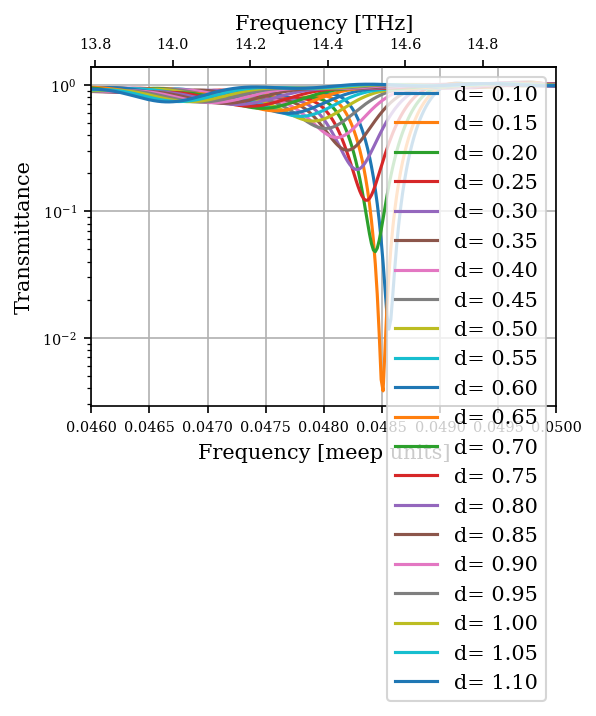

In [8]:
print("Beginning Resonance search")

multifig = plt.figure(1)

plt.xlabel("Frequency [meep units]")
plt.ylabel("Transmittance")
plt.yscale('log', nonpositive='clip')

axtot = plt.gca()

def MU2THz(x):
    return x *freq_unit*1e-12


def THz2MU(x):
    return x /(freq_unit*1e-12)

secax = axtot.secondary_xaxis('top', functions=(MU2THz, THz2MU))
secax.set_xlabel('Frequency [THz]')




for index,d in enumerate(distances):
    #Geometry objects
    print("###############")
    print("Beginning iteration: ",index)
    print("Distance: ",d)

    #Position properties
    wvg_x = 0
    wvg_y = -(wvg_width + d + ring_w*2 + ring_r*2)/2 + wvg_width/2

    ring_x = 0
    ring_y = wvg_y + wvg_width/2 + d + ring_w + ring_r

    #Soure parameters
    source_x = x_bound_low + 1
    source_y = wvg_y

    source_width = wvg_width

    #prediction of fundamental resonance
    fund_resonance = 1/(2*pi*(ring_r+ring_w/2)*n_ring)

    #Resonance values
    m = 8
    f_central_guess = 0.048
    df_guess = 0.005


    #Monitor parameters
    
    #central frequency
    f_mon = f_central_guess
    #width of sampled frequency band
    df_mon = df_guess

    #input
    mon_1_x = source_x + 2
    mon_1_y = wvg_y
    mon_1_width = wvg_width + 4

    #output
    mon_2_x = x_bound_up - 4
    mon_2_y = wvg_y
    mon_2_width = wvg_width + 4

    #number of sampling points in frequency for fourier transform of fields accumulated
    N_freq = 300

    check_pt = mp.Vector3(mon_2_x - 0.1, mon_2_y)
    
    waveguide = mp.Block(mp.Vector3(mp.inf, wvg_width, mp.inf),
                    center = mp.Vector3(wvg_x, wvg_y),
                    material = mp.Medium(index=n_wvg))
    ext_ring = mp.Cylinder(radius=ring_r+ring_w,
                    center=mp.Vector3(ring_x, ring_y),
                    material = mp.Medium(index=n_ring))
    int_ring = mp.Cylinder(radius=ring_r,
                    center=mp.Vector3(ring_x, ring_y))

    geometry = [waveguide,
            ext_ring,
            int_ring]

    #define sources
    #gaussian pulse with f_central and df
    sources = [mp.Source(mp.GaussianSource(frequency=f_central_guess, fwidth=df_guess*3),
                        component=mp.Ez,
                        center=mp.Vector3(source_x, source_y),
                        size=mp.Vector3(0, source_width))]

    #define boundary conditions
    pml_layers = [mp.PML(pml_thickness)]

    #Instance simulation with chosen parameters
    sim = mp.Simulation(cell_size=cell,
                        boundary_layers=pml_layers,
                        sources=sources,
                        geometry=geometry,
                        resolution=resolution)

    # Flux Monitor 1
    incident_fr = mp.FluxRegion(center=mp.Vector3(mon_1_x, mon_1_y), size=mp.Vector3(0, mon_1_width, 0))
    incident = sim.add_flux(f_mon, df_mon, N_freq, incident_fr)

    # Flux Monitor 2
    tran_fr = mp.FluxRegion(center=mp.Vector3(mon_2_x, mon_2_y), size=mp.Vector3(0,mon_2_width,0))
    tran = sim.add_flux(f_mon, df_mon, N_freq, tran_fr)

    #Simulate
    mp.verbosity(0)
    sim.run( until_after_sources = mp.stop_when_fields_decayed(50, mp.Ez, check_pt, 1e-3))

    #Get fluxes from fourier transformed fields transmitted
    norm_tran_flux = mp.get_fluxes(tran)

    #Get fluxes from fourier transformed incident fields
    norm_inc_flux = mp.get_fluxes(incident)

    flux_freqs = mp.get_flux_freqs(tran)

    Tr = np.array(norm_tran_flux)/np.array(norm_inc_flux)
    freq_res_main = flux_freqs[np.argmin(Tr)]

    loop_f_central_resonance = np.append(loop_f_central_resonance, freq_res_main)
    print("Resonance frequency: ", freq_res_main )

    loop_attenuation = np.append(loop_attenuation, Tr[np.argmin(Tr)])
    print("Resonance attenuation: ", Tr[np.argmin(Tr)])

    plt.figure()
    plt.plot(flux_freqs, Tr, color='k')

    plt.xlabel("Frequency [meep units]")
    plt.ylabel("Transmittance")
    plt.yscale('log', nonpositive='clip')
    
    ax = plt.gca()

    def MU2THz(x):
        return x *freq_unit*1e-12


    def THz2MU(x):
        return x /(freq_unit*1e-12)

    secax = ax.secondary_xaxis('top', functions=(MU2THz, THz2MU))
    secax.set_xlabel('Frequency [THz]')
    

    plt.axvline(freq_res_main , color='k', linestyle='--')

    plt.title('Spectrum at d= '+"{:.2f}".format(d)+"m.u.")

    plt.grid()

    plt.savefig('img/final/spectrum' +str(index)+ '.png')

    plt.figure(1)
    plt.plot(flux_freqs, Tr, label='d= '+"{:.2f}".format(d))
    
    

    sim.reset_meep()
print(loop_f_central_resonance)

plt.figure(1)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)
plt.grid()
plt.xlim([0.046,0.05])
plt.savefig('img/final/spectrum_tot.png')

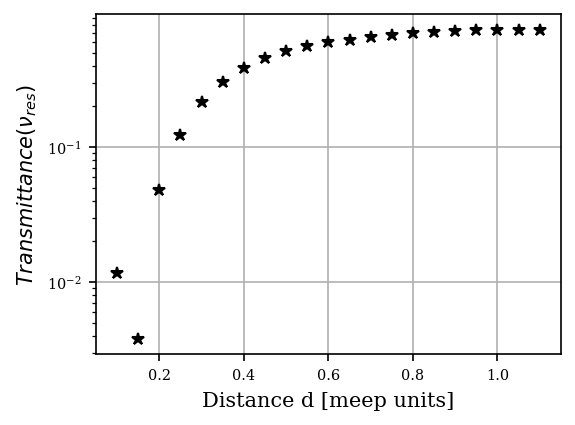

In [9]:
plt.plot(distances, loop_attenuation, "k*")

plt.xlabel(r"Distance d [meep units]")
plt.ylabel(r"$Transmittance(\nu_{res})$")

plt.yscale('log', nonpositive='clip')

plt.grid()
plt.show()

# $\Delta \phi$ calculation

In [10]:
run_time = 500

Delta_Phi_list = []

###############
Beginning iteration:  0
Distance:  0.1
Frequency:  0.048560200668896325


FloatProgress(value=0.0, description='0% done ', max=500.0)

(900, 3)
K_init:  0.7059758772111795  phi_init: 6.0890419409460605
K_fin:  0.708363619715567  phi_fin: 1.3228690608773563
Delta Phi: 1.517012427110882 , Degrees:  86.91840954235097
###############
Beginning iteration:  1
Distance:  0.15000000000000002
Frequency:  0.04851003344481605


FloatProgress(value=0.0, description='0% done ', max=500.0)

(900, 2)
K_init:  0.7059758772111795  phi_init: 6.230237116388295
K_fin:  0.7091631271877425  phi_fin: 1.322589233230472
Delta Phi: 1.375537424021763 , Degrees:  78.81248895874417
###############
Beginning iteration:  2
Distance:  0.20000000000000004
Frequency:  0.04844314381270903


FloatProgress(value=0.0, description='0% done ', max=500.0)

(900, 2)
K_init:  0.7059758772111795  phi_init: 0.15884457237206817
K_fin:  0.7091631272211621  phi_fin: 1.3935055449891518
Delta Phi: 1.2346609726170836 , Degrees:  70.7408628604762
###############
Beginning iteration:  3
Distance:  0.25000000000000006
Frequency:  0.04835953177257525


FloatProgress(value=0.0, description='0% done ', max=500.0)

(900, 2)
K_init:  0.702031877920412  phi_init: 0.29543841600640874
K_fin:  0.7091631272025706  phi_fin: 1.535338170909255
Delta Phi: 1.2398997549028463 , Degrees:  71.04102297523829
###############
Beginning iteration:  4
Distance:  0.30000000000000004
Frequency:  0.04829264214046823


FloatProgress(value=0.0, description='0% done ', max=500.0)

(900, 3)
K_init:  0.702031877850246  phi_init: 0.5060479774367153
K_fin:  0.7083636197614157  phi_fin: 1.6416326883810628
Delta Phi: 1.1355847109443475 , Degrees:  65.06421121669466
###############
Beginning iteration:  5
Distance:  0.3500000000000001
Frequency:  0.04820903010033445


FloatProgress(value=0.0, description='0% done ', max=500.0)

(900, 2)
K_init:  0.6981317007977218  phi_init: 0.5934119456776266
K_fin:  0.7083636198116867  phi_fin: 1.7124690490405685
Delta Phi: 1.119057103362942 , Degrees:  64.1172490568317
###############
Beginning iteration:  6
Distance:  0.40000000000000013
Frequency:  0.04810869565217391


/tmp/ipykernel_38414/4244319209.py:111: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


FloatProgress(value=0.0, description='0% done ', max=500.0)

(900, 2)
K_init:  0.6942746195778451  phi_init: 0.7955230015991823
K_fin:  0.7020318779449238  phi_fin: 2.003715983515974
Delta Phi: 1.2081929819167918 , Degrees:  69.22435870115797
###############
Beginning iteration:  7
Distance:  0.45000000000000007
Frequency:  0.048008361204013375


FloatProgress(value=0.0, description='0% done ', max=500.0)

(900, 2)
K_init:  0.690459923865879  phi_init: 0.9493823953151583
K_fin:  0.7020318779311419  phi_fin: 2.144122359470142
Delta Phi: 1.1947399641549836 , Degrees:  68.45355756169182
###############
Beginning iteration:  8
Distance:  0.5000000000000001
Frequency:  0.047908026755852845


FloatProgress(value=0.0, description='0% done ', max=500.0)

(900, 3)
K_init:  0.6904599238658788  phi_init: 1.2255663648615105
K_fin:  0.7020318779186752  phi_fin: 2.2845287354973305
Delta Phi: 1.05896237063582 , Degrees:  60.6740745006009
###############
Beginning iteration:  9
Distance:  0.5500000000000002
Frequency:  0.04780769230769231


FloatProgress(value=0.0, description='0% done ', max=500.0)

(900, 2)
K_init:  0.688191161782696  phi_init: 1.433158094163268
K_fin:  0.7020318778837582  phi_fin: 2.354731924188167
Delta Phi: 0.921573830024899 , Degrees:  52.80229097013342
###############
Beginning iteration:  10
Distance:  0.6000000000000002
Frequency:  0.047690635451505016


FloatProgress(value=0.0, description='0% done ', max=500.0)

(900, 2)
K_init:  0.6874382174075852  phi_init: 1.7426558809242536
K_fin:  0.7020318779311955  phi_fin: 2.495138298436421
Delta Phi: 0.7524824175121676 , Degrees:  43.11406668124831
###############
Beginning iteration:  11
Distance:  0.6500000000000001
Frequency:  0.04759030100334448


FloatProgress(value=0.0, description='0% done ', max=500.0)

(900, 2)
K_init:  0.6874382174029839  phi_init: 2.017631168629098
K_fin:  0.6981317008576826  phi_fin: 2.7110781030168525
Delta Phi: 0.6934469343877545 , Degrees:  39.731582656703644
###############
Beginning iteration:  12
Distance:  0.7000000000000002
Frequency:  0.047473244147157194


FloatProgress(value=0.0, description='0% done ', max=500.0)

(900, 3)
K_init:  0.6851892373871612  phi_init: 2.2902450263203136
K_fin:  0.7205487728758808  phi_fin: 2.046358544319866
Delta Phi: -0.24388648200044738 , Degrees:  -13.973666098918955
###############
Beginning iteration:  13
Distance:  0.7500000000000002
Frequency:  0.04737290969899666


FloatProgress(value=0.0, description='0% done ', max=500.0)

(900, 2)
K_init:  0.6822133884627917  phi_init: 2.5258950721898366
K_fin:  0.7222052079782806  phi_fin: 2.0330076512732376
Delta Phi: -0.492887420916599 , Degrees:  -28.240368993609255
###############
Beginning iteration:  14
Distance:  0.8000000000000002
Frequency:  0.047255852842809365


FloatProgress(value=0.0, description='0% done ', max=500.0)

(900, 2)
K_init:  0.6822133884100448  phi_init: 2.867001765010226
K_fin:  0.7230362843915731  phi_fin: 2.098612799347112
Delta Phi: -0.7683889656631138 , Degrees:  -44.02544475691915
###############
Beginning iteration:  15
Distance:  0.8500000000000002
Frequency:  0.04713879598662207


FloatProgress(value=0.0, description='0% done ', max=500.0)

(900, 2)
K_init:  0.6799984098940708  phi_init: 3.134792670233143
K_fin:  0.7247041877457584  phi_fin: 2.1867948833036364
Delta Phi: -0.9479977869295064 , Degrees:  -54.316272178803
###############
Beginning iteration:  16
Distance:  0.9000000000000002
Frequency:  0.047038461538461536


FloatProgress(value=0.0, description='0% done ', max=500.0)

(900, 3)
K_init:  0.6719984285452995  phi_init: 3.2731923451734666
K_fin:  0.6874382174799207  phi_fin: 3.557492772850569
Delta Phi: 0.2843004276771026 , Degrees:  16.28921461966228
###############
Beginning iteration:  17
Distance:  0.9500000000000003
Frequency:  0.046938127090301006


FloatProgress(value=0.0, description='0% done ', max=500.0)

(900, 2)
K_init:  0.6719984285528381  phi_init: 3.541991716755163
K_fin:  0.6829549246501743  phi_fin: 3.756252087225368
Delta Phi: 0.21426037047020507 , Degrees:  12.276214944852205
###############
Beginning iteration:  18
Distance:  1.0000000000000004
Frequency:  0.046854515050167224


FloatProgress(value=0.0, description='0% done ', max=500.0)

(900, 2)
K_init:  0.6684239688737048  phi_init: 3.687472228720811
K_fin:  0.6829549247995313  phi_fin: 3.8245475748981708
Delta Phi: 0.13707534617735995 , Degrees:  7.8538388112574475
###############
Beginning iteration:  19
Distance:  1.0500000000000003
Frequency:  0.04675418060200669


FloatProgress(value=0.0, description='0% done ', max=500.0)

(900, 2)
K_init:  0.6684239688488824  phi_init: 3.977122614650476
K_fin:  0.6777977679184757  phi_fin: 4.092204018043953
Delta Phi: 0.11508140339347683 , Degrees:  6.593678714888733
###############
Beginning iteration:  20
Distance:  1.1000000000000005
Frequency:  0.04665384615384616


FloatProgress(value=0.0, description='0% done ', max=500.0)

(900, 3)
K_init:  0.664887334053704  phi_init: 4.141694018091599
K_fin:  0.6756113233154242  phi_fin: 4.307022187679214
Delta Phi: 0.16532816958761565 , Degrees:  9.472606351993509


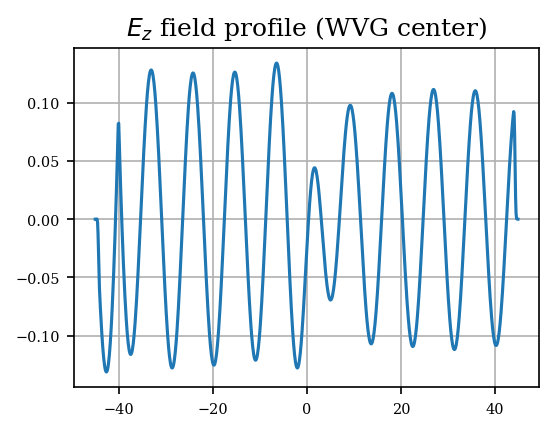

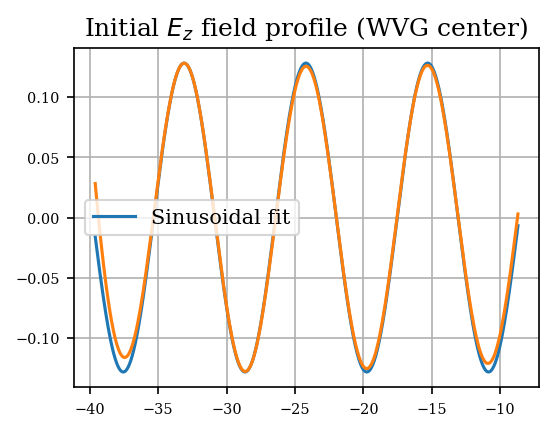

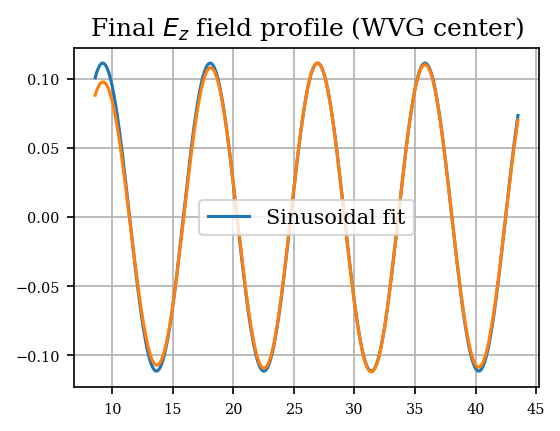

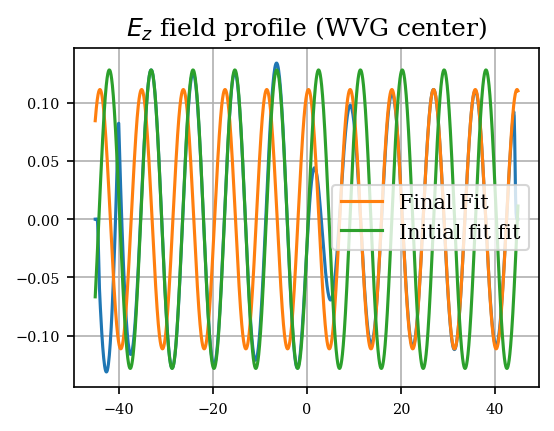

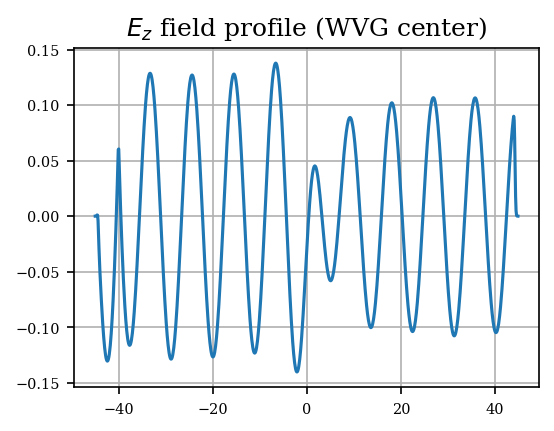

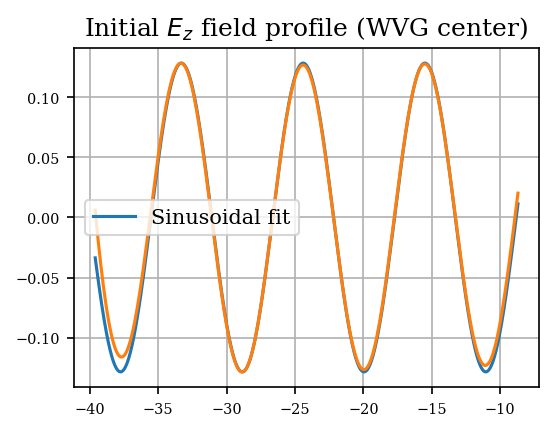

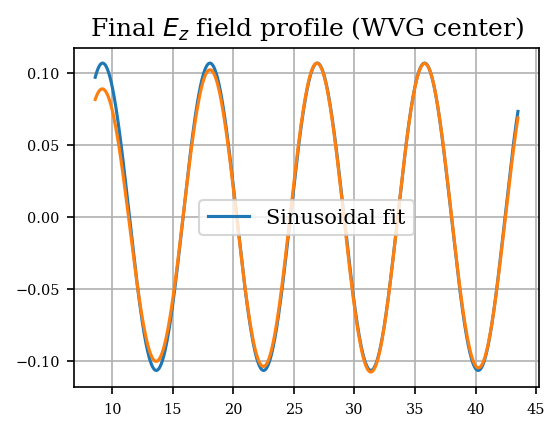

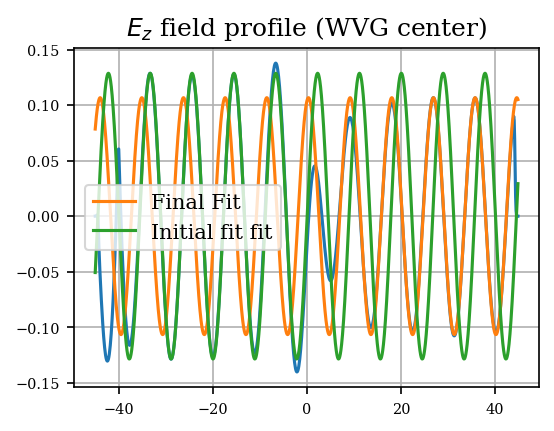

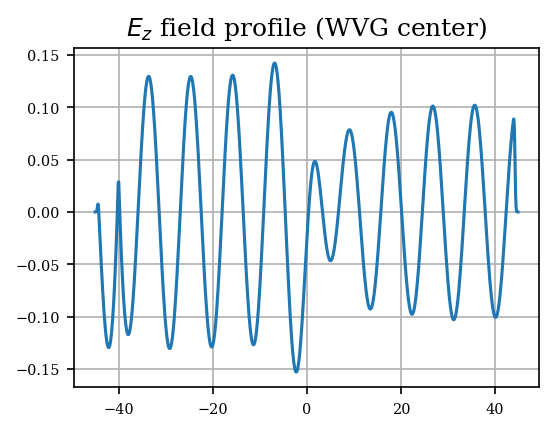

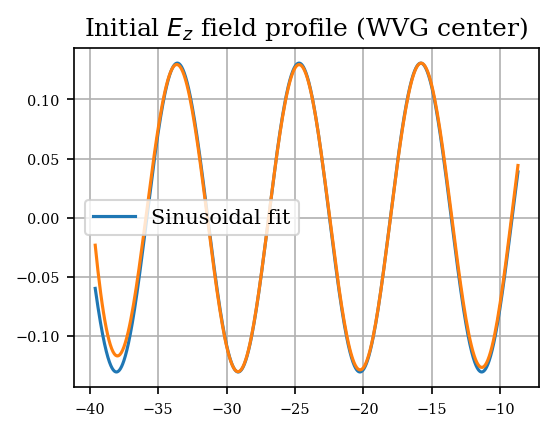

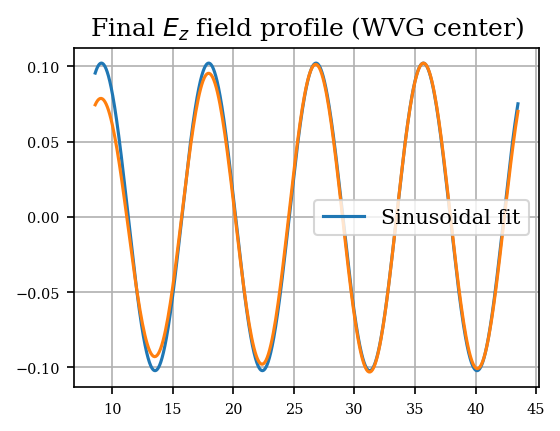

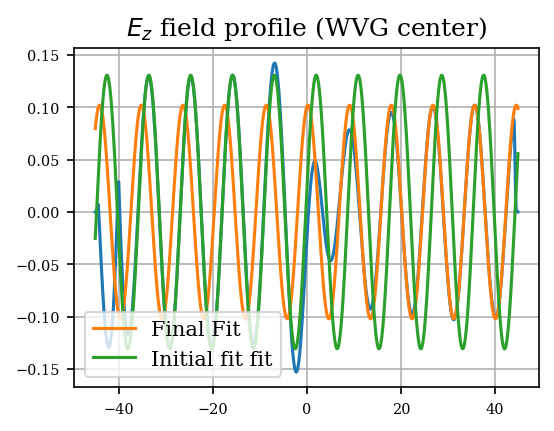

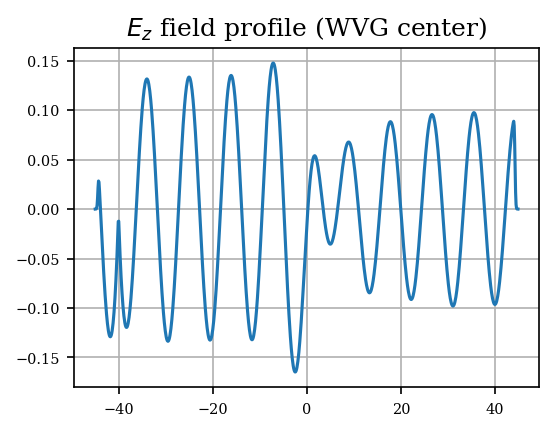

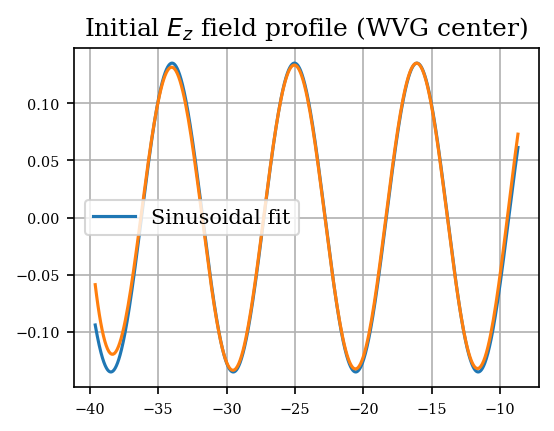

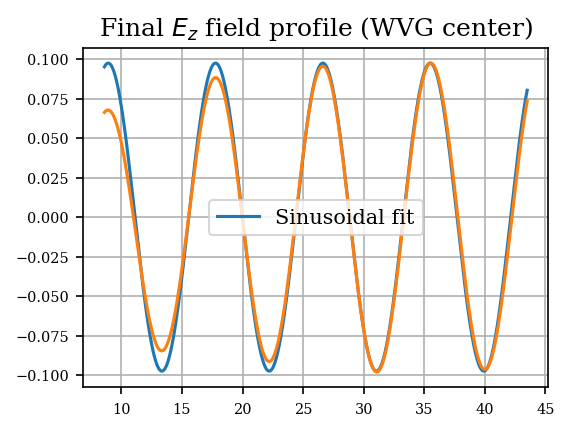

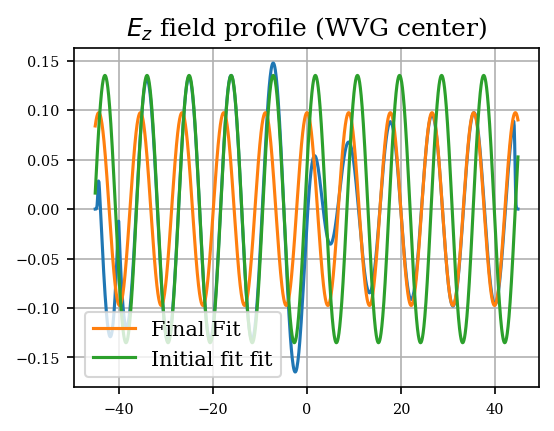

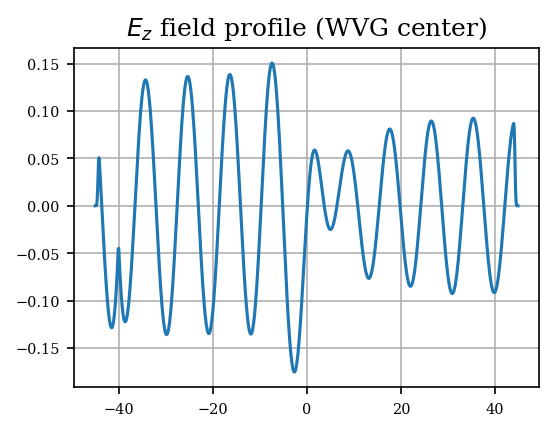

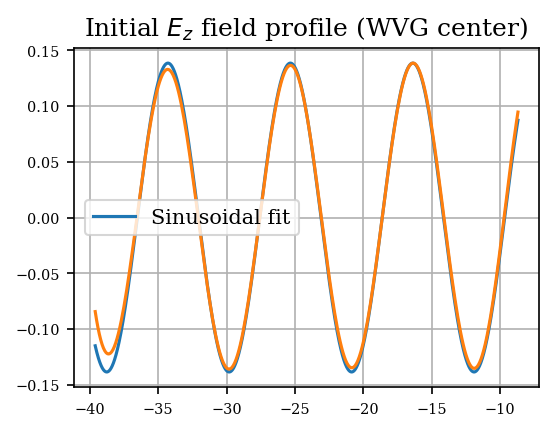

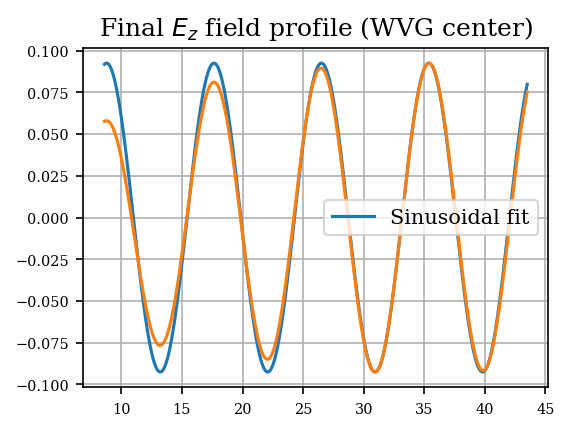

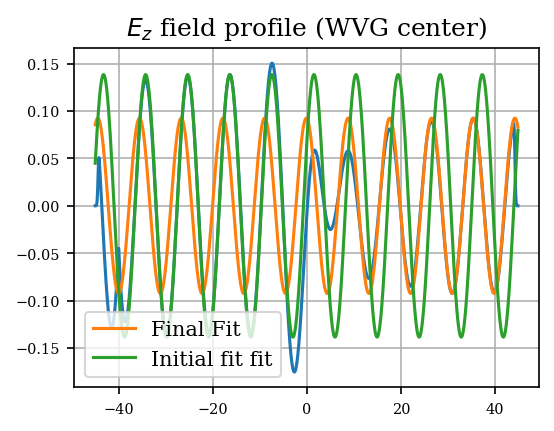

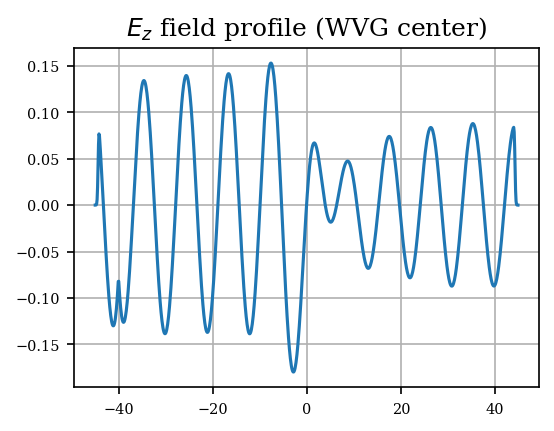

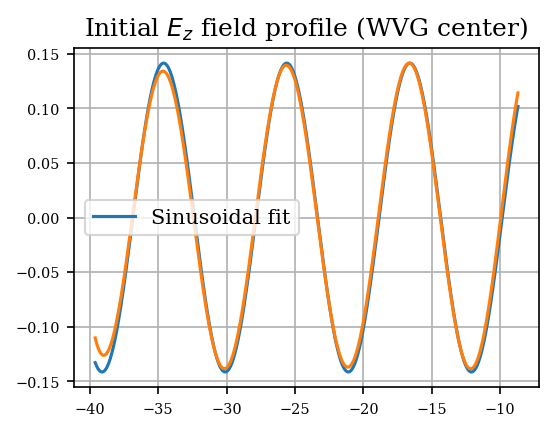

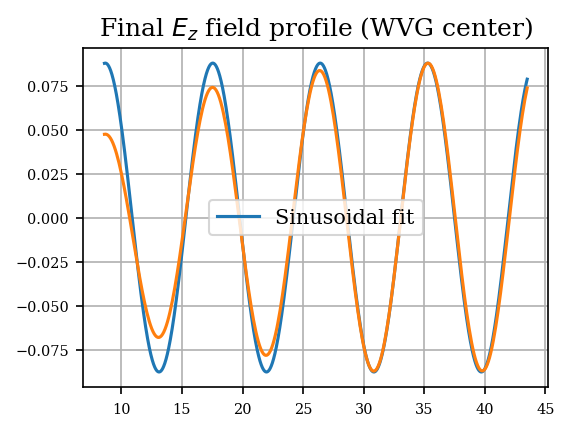

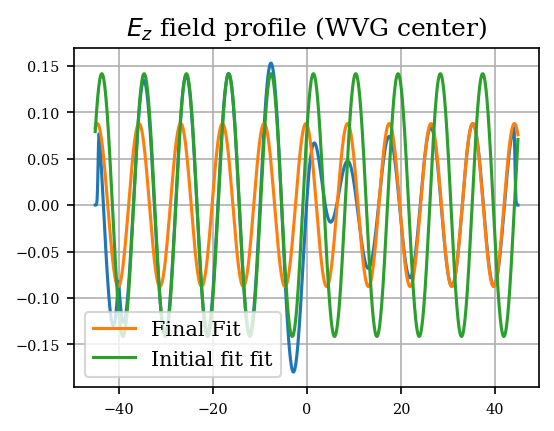

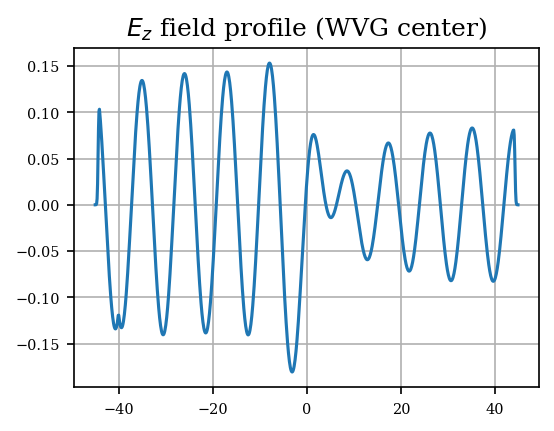

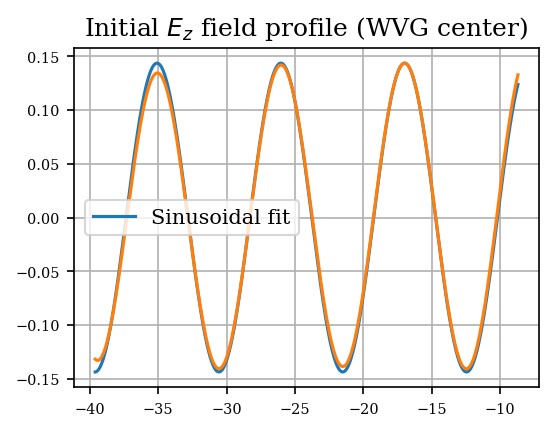

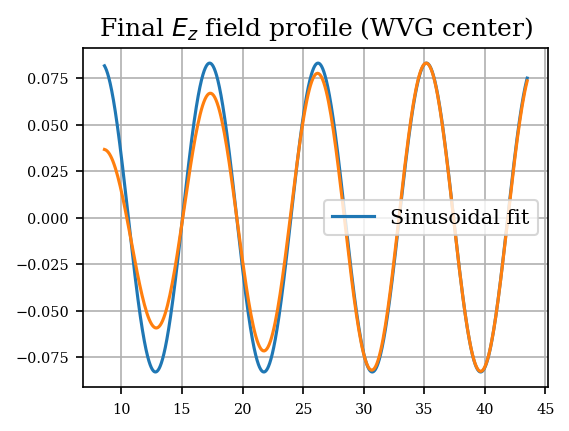

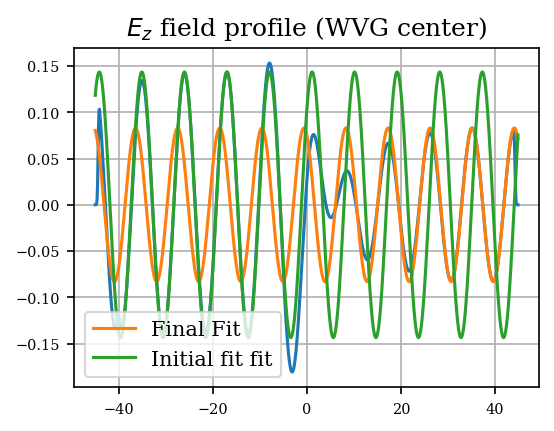

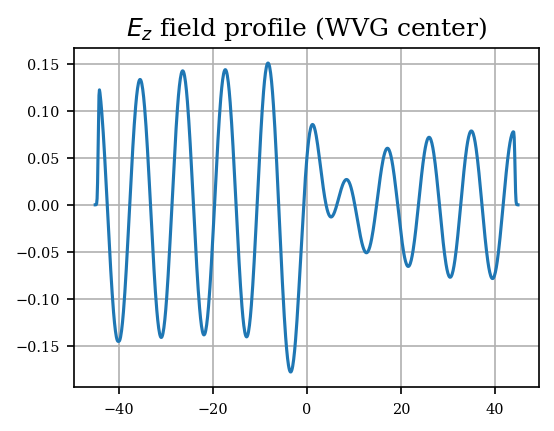

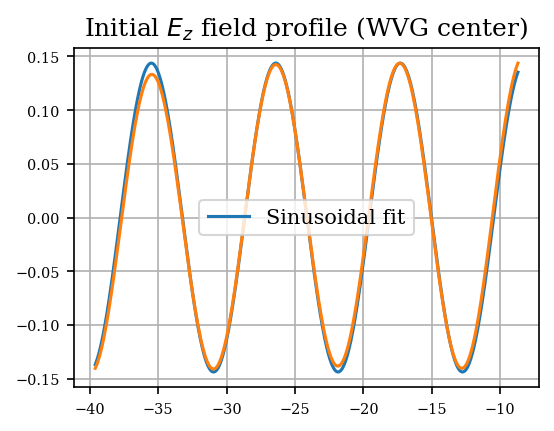

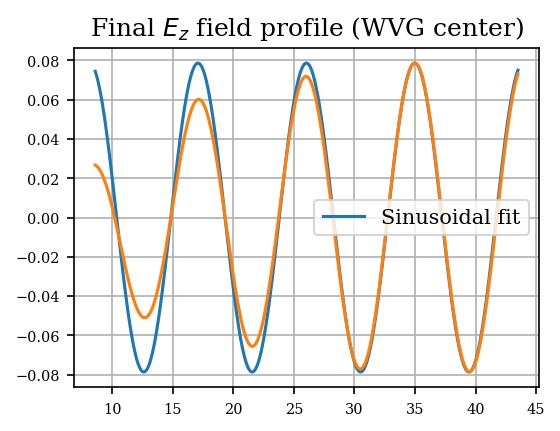

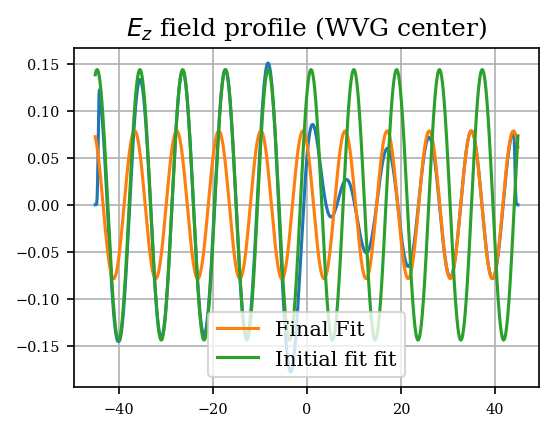

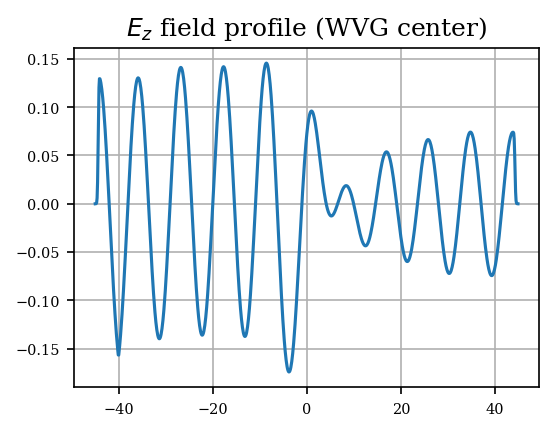

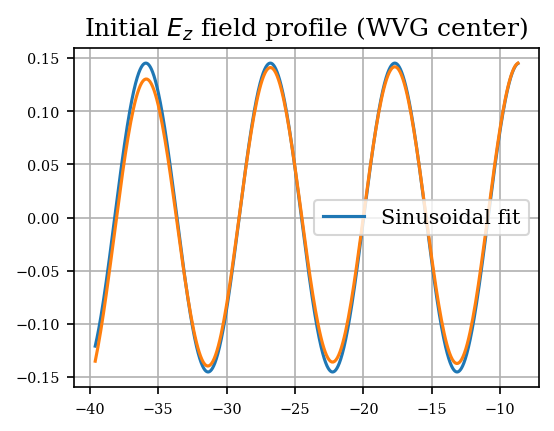

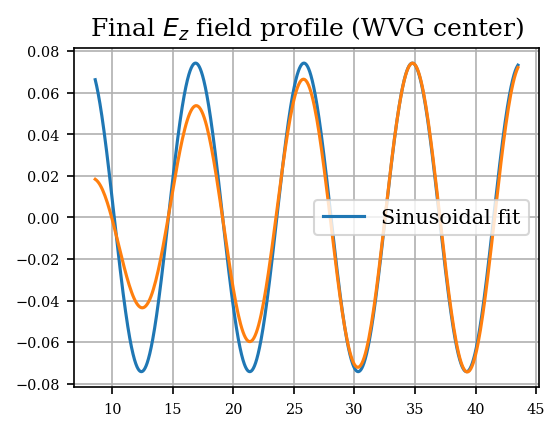

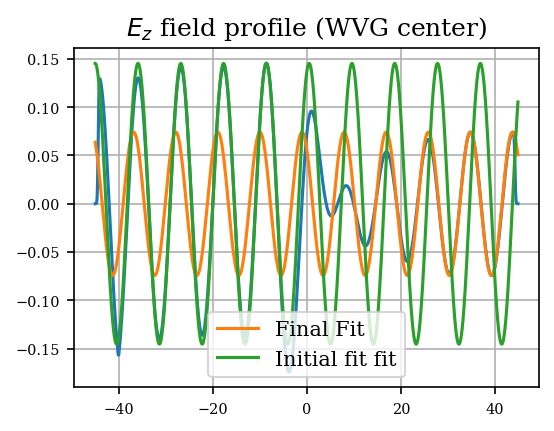

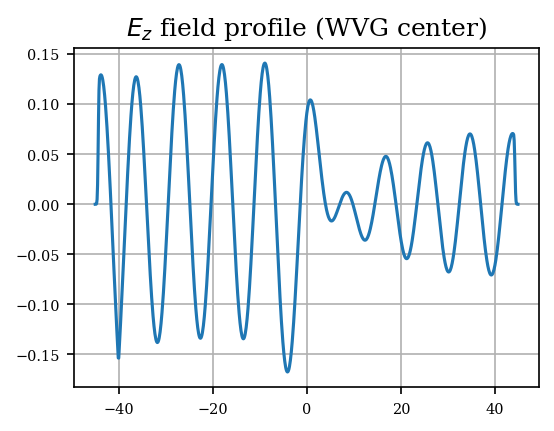

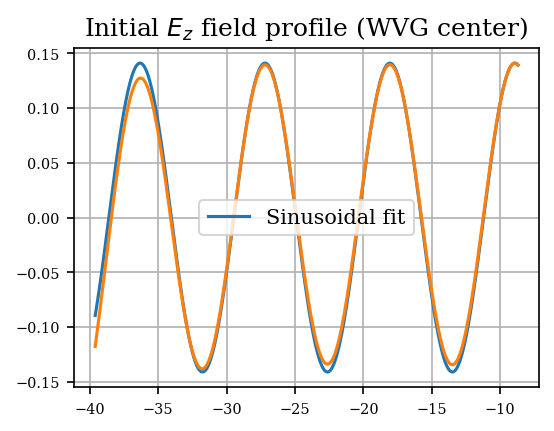

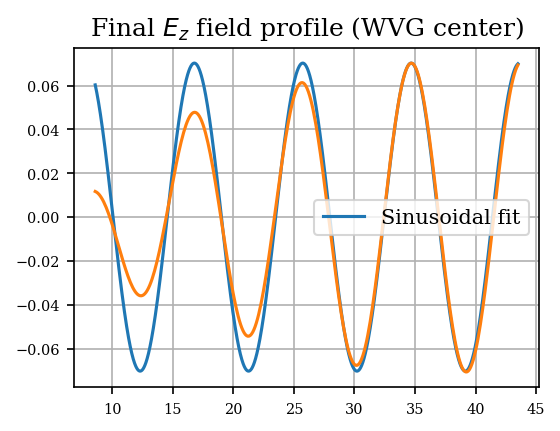

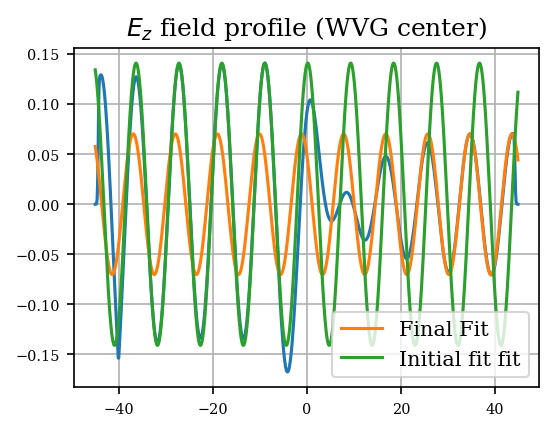

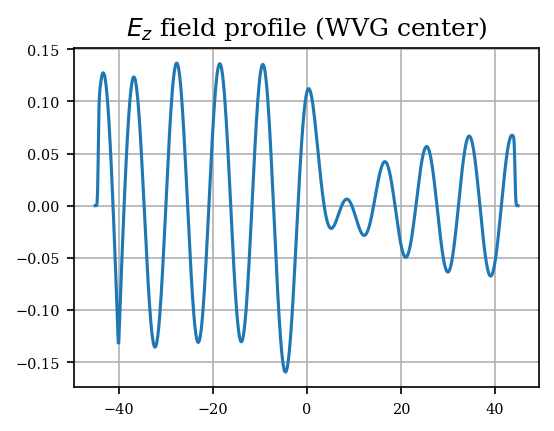

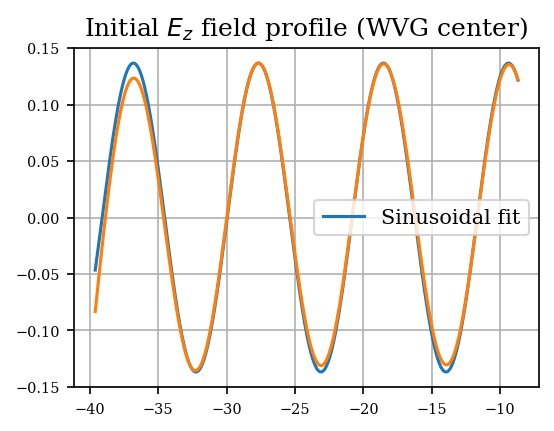

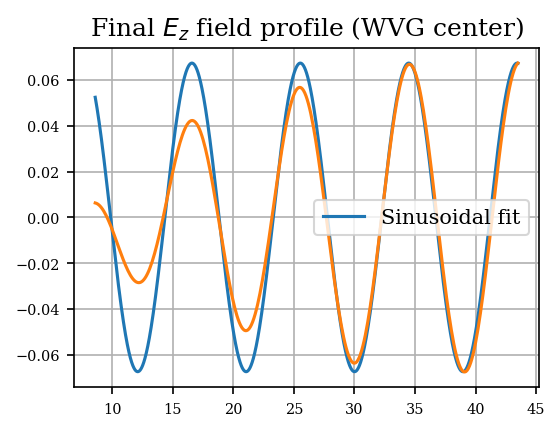

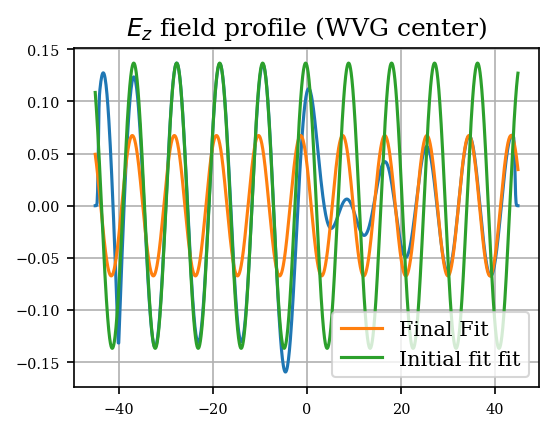

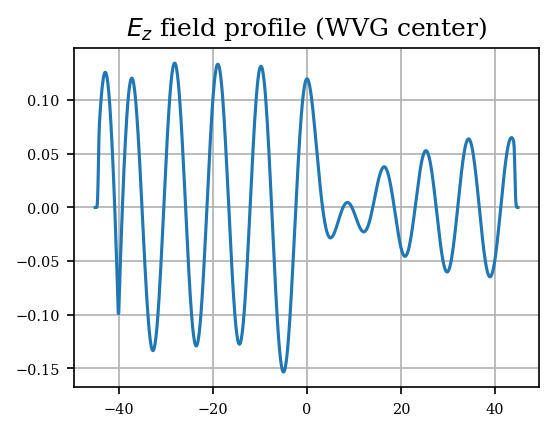

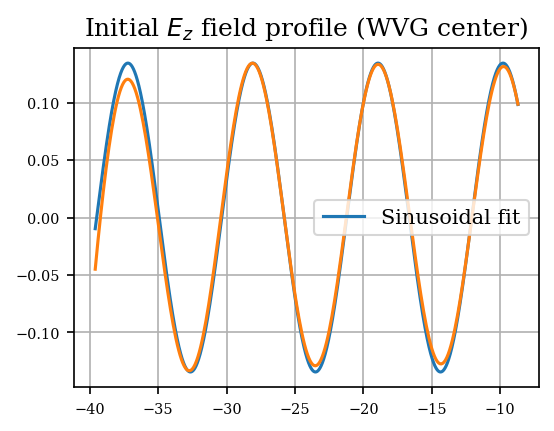

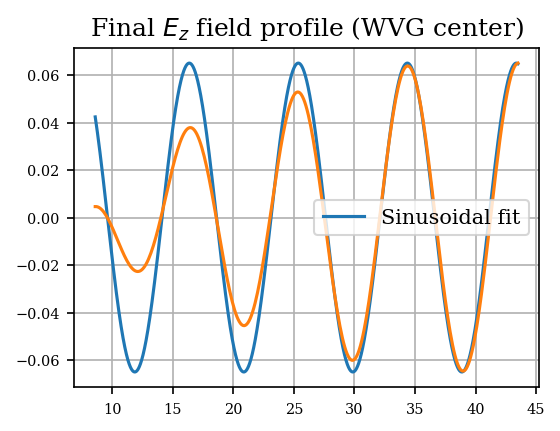

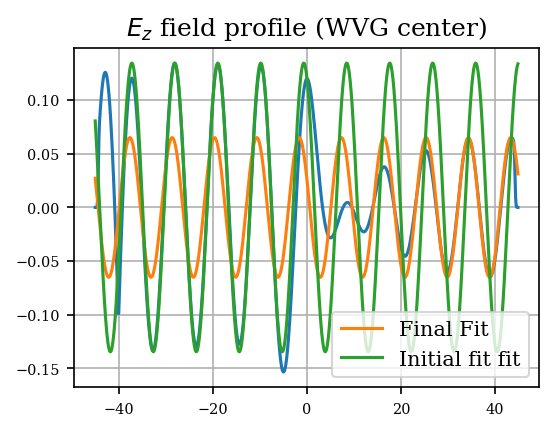

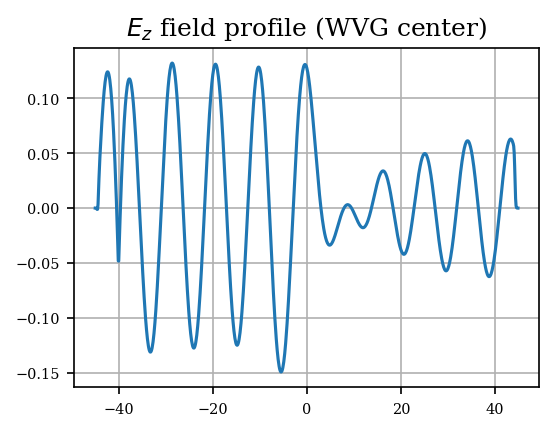

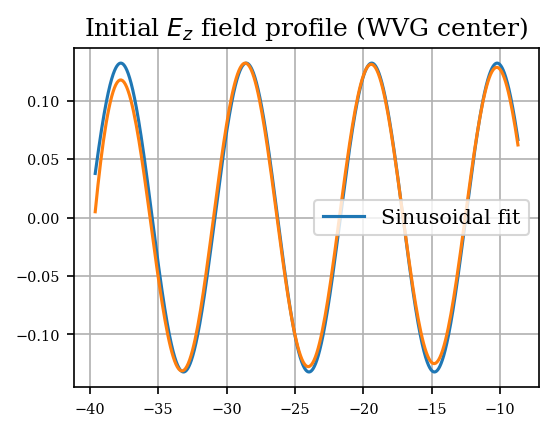

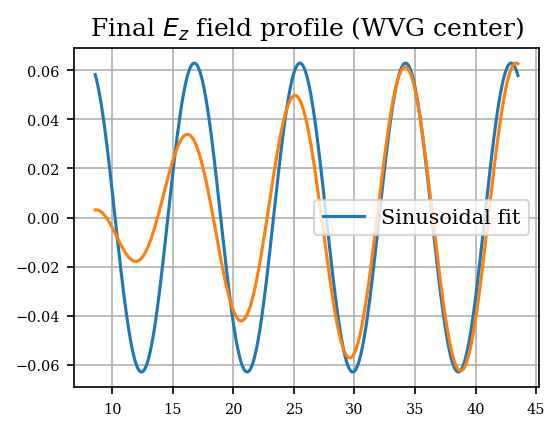

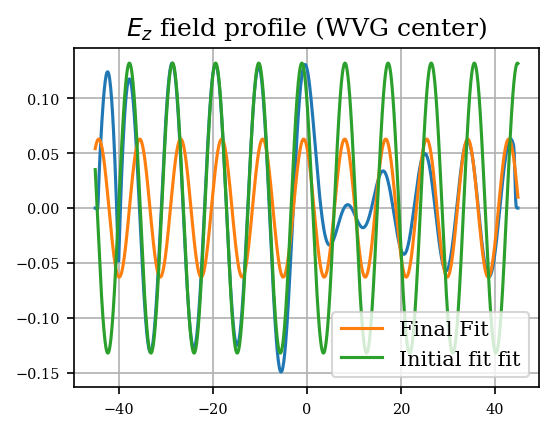

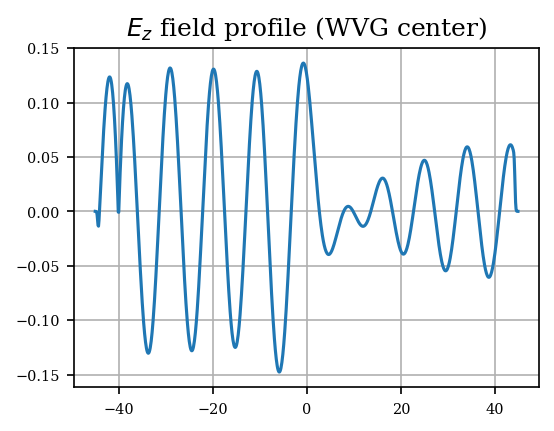

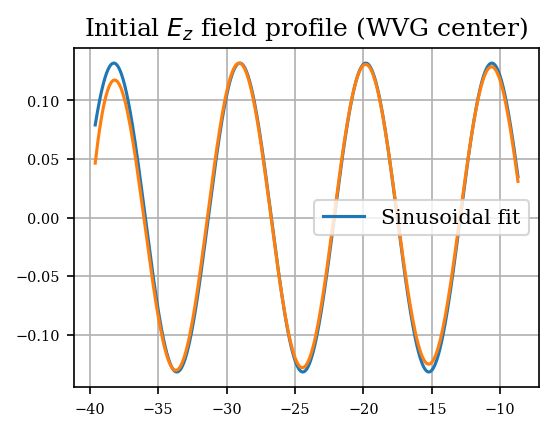

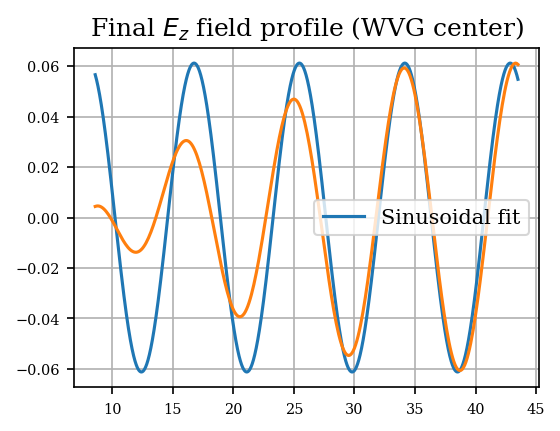

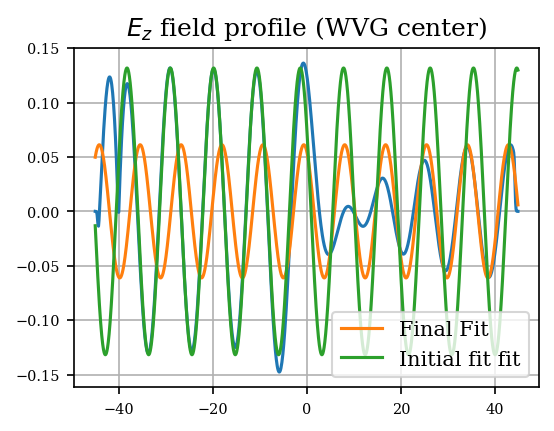

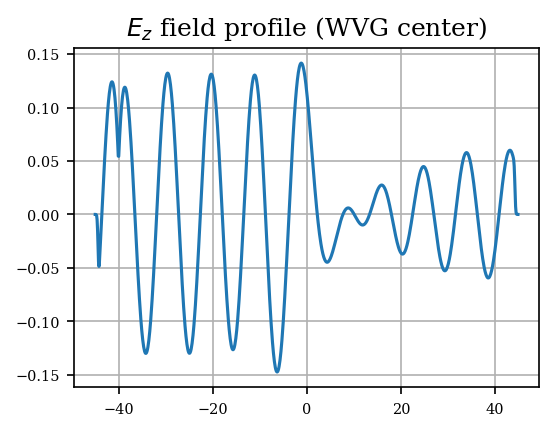

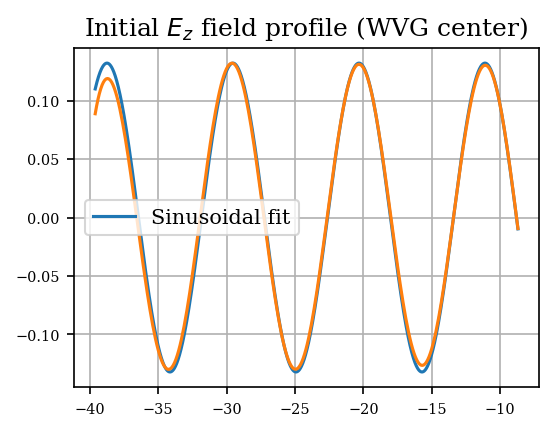

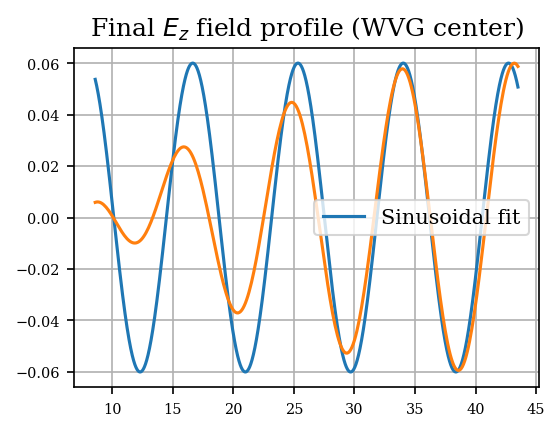

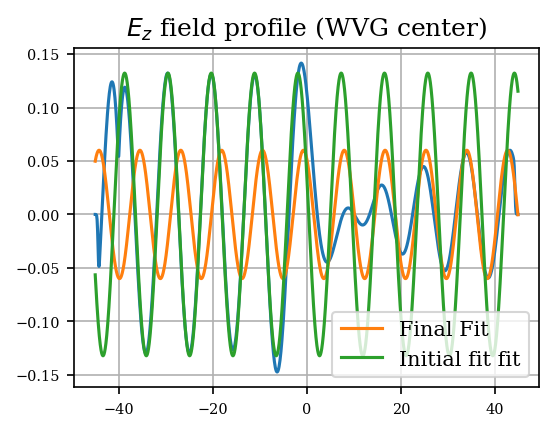

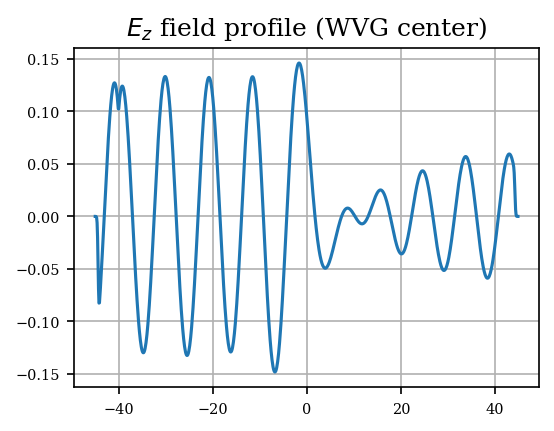

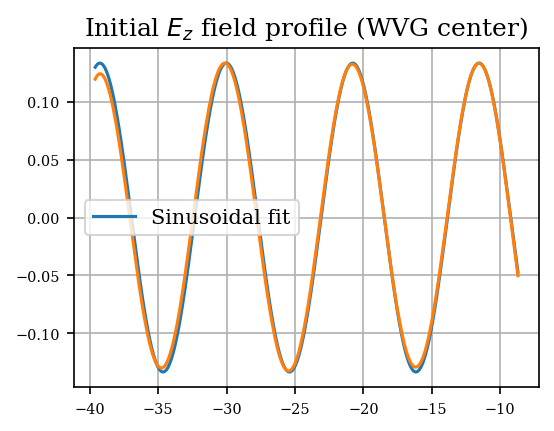

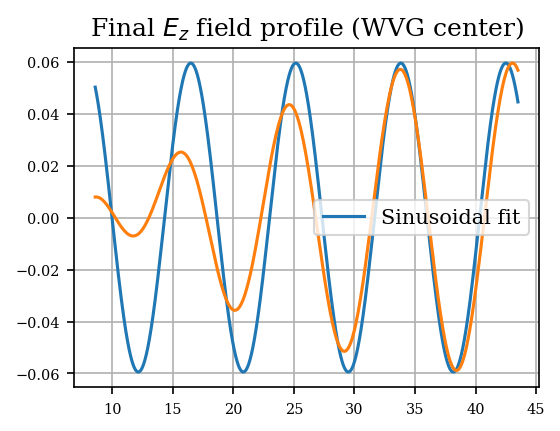

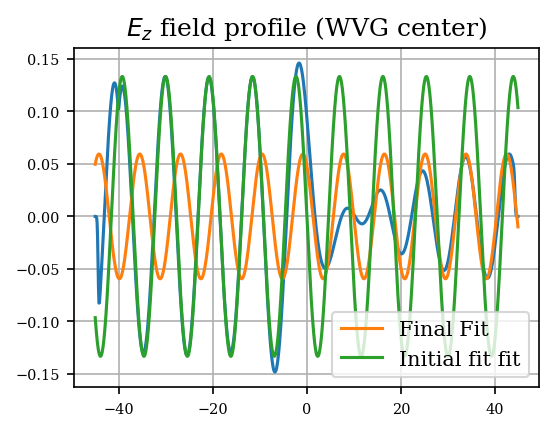

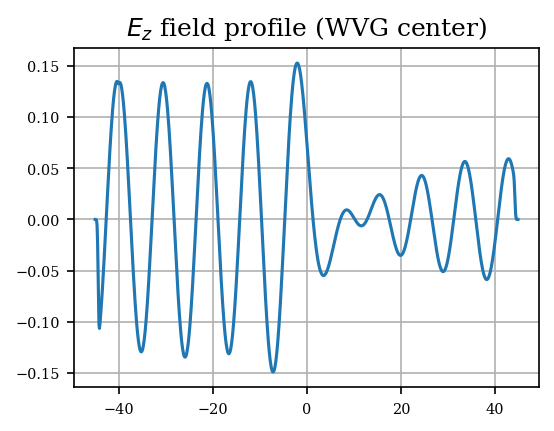

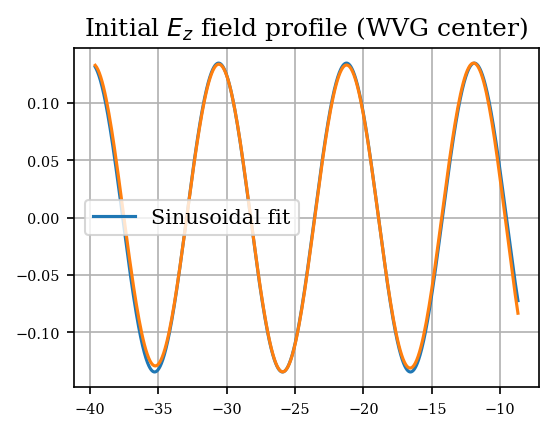

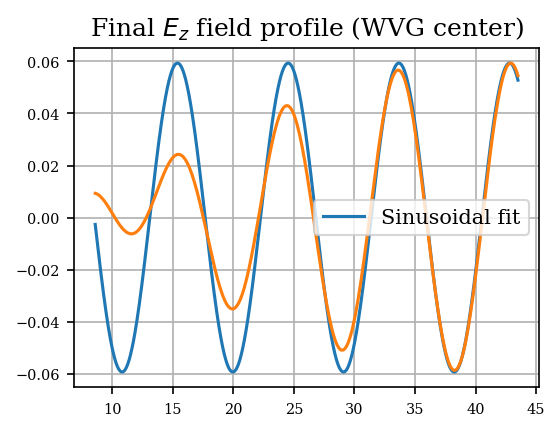

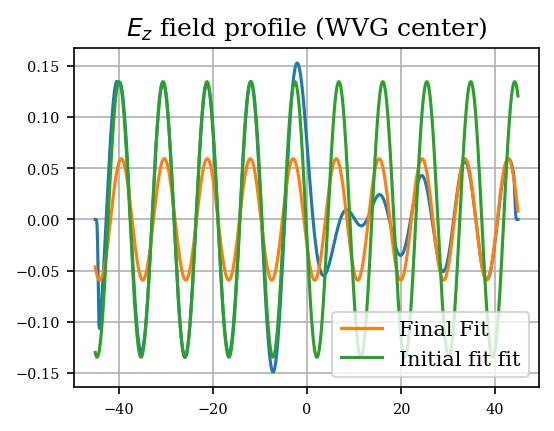

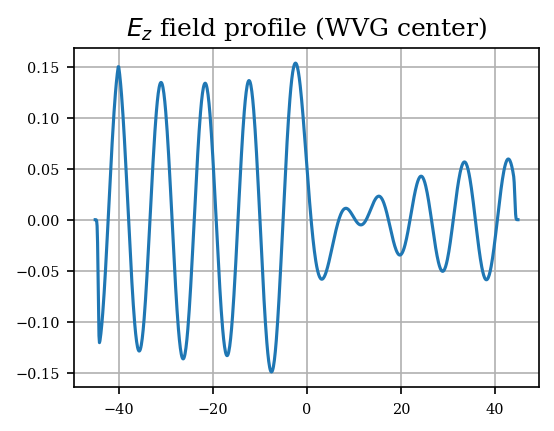

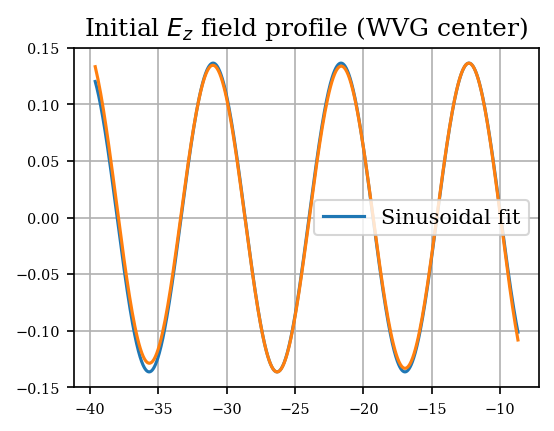

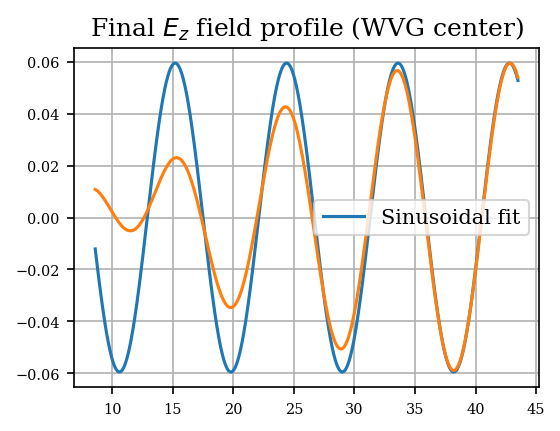

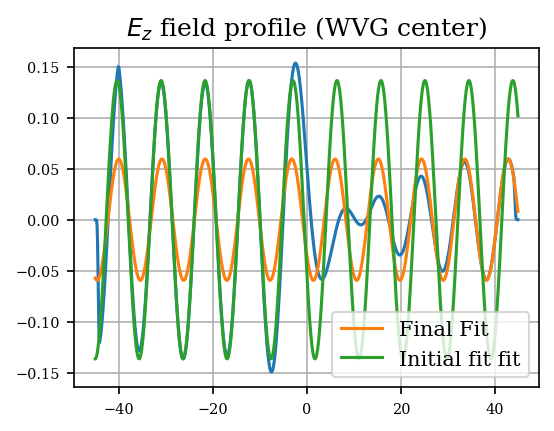

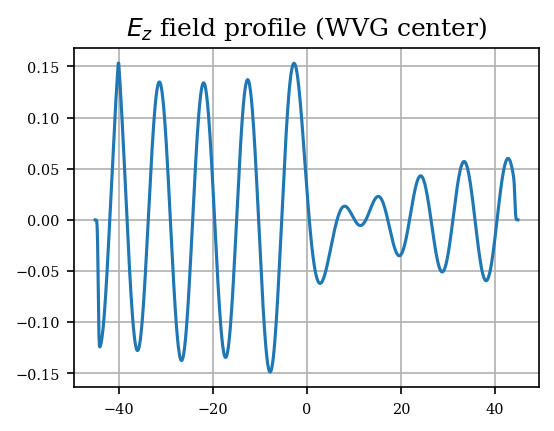

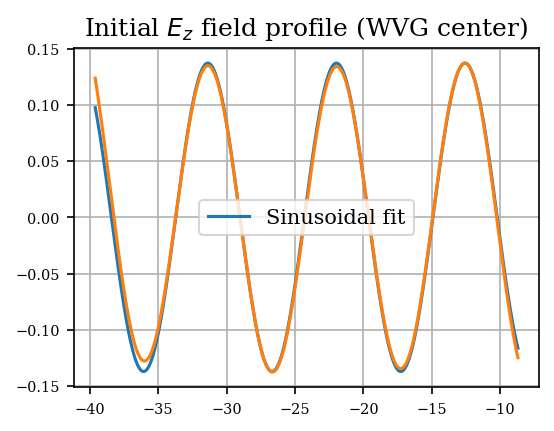

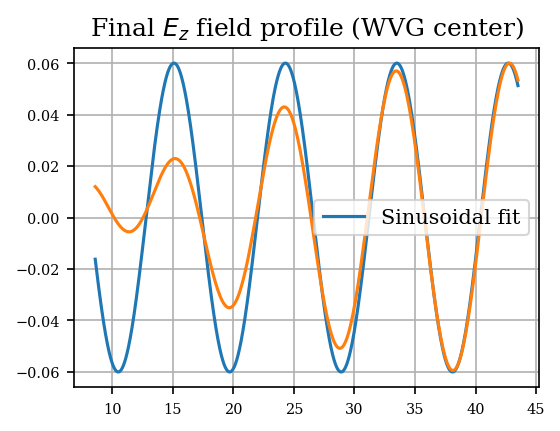

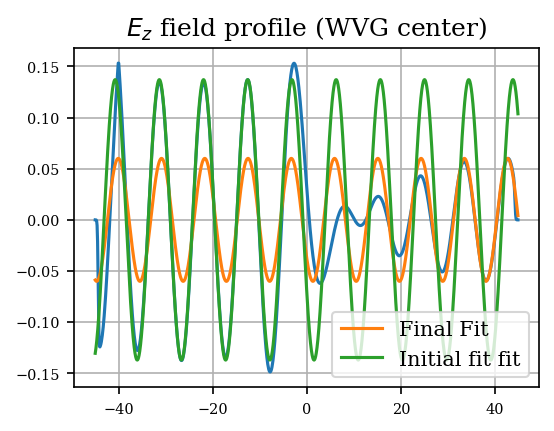

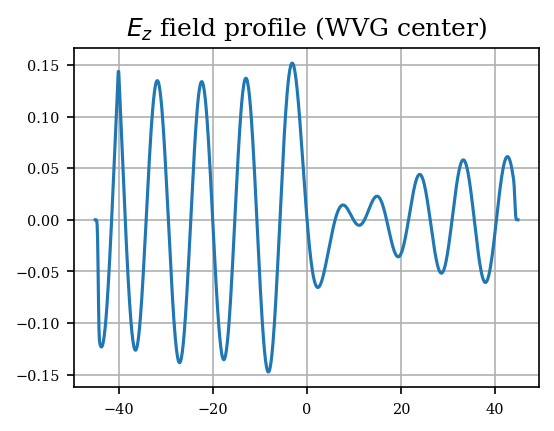

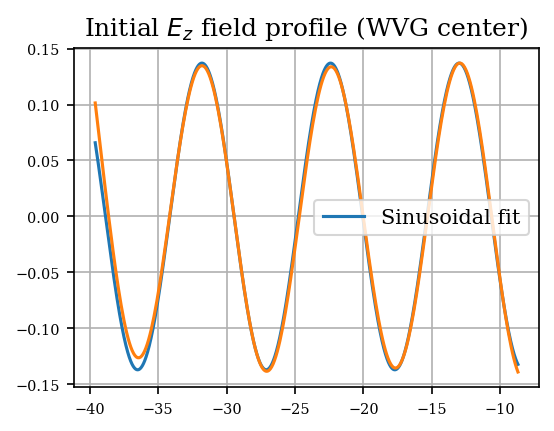

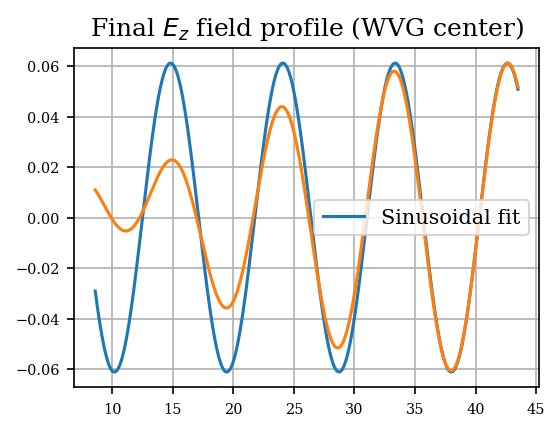

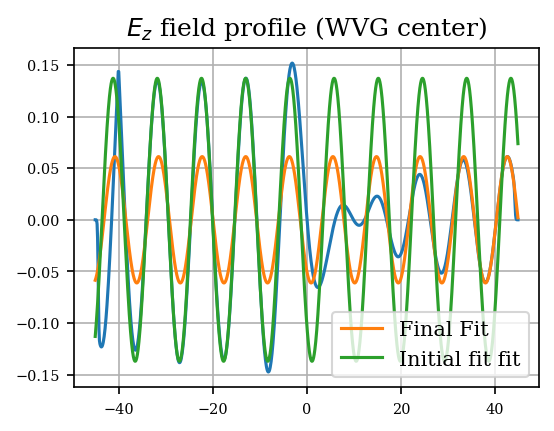

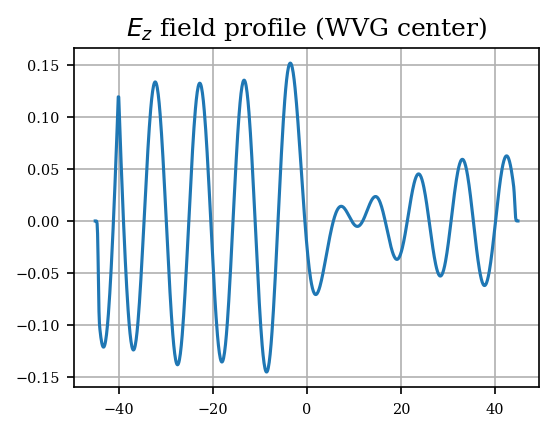

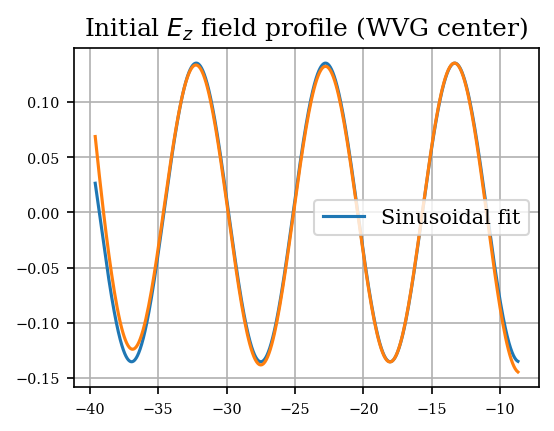

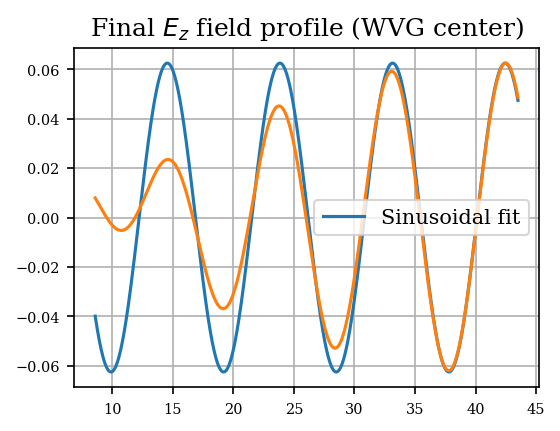

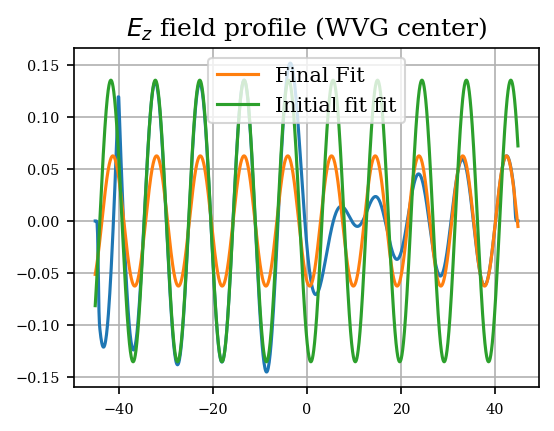

In [11]:
for index,d in enumerate(distances):
    print("###############")
    print("Beginning iteration: ",index)
    print("Distance: ", d)
    print("Frequency: ", loop_f_central_resonance[index])


    #Position properties
    wvg_x = 0
    wvg_y = -(wvg_width + d + ring_w*2 + ring_r*2)/2 + wvg_width/2

    ring_x = 0
    ring_y = wvg_y + wvg_width/2 + d + ring_w + ring_r

    #Soure parameters
    source_x = x_bound_low + 4
    source_y = wvg_y

    source_width = wvg_width


    #Geometry objects
    waveguide = mp.Block(mp.Vector3(mp.inf, wvg_width, mp.inf),
                        center = mp.Vector3(wvg_x, wvg_y),
                        material = mp.Medium(index=n_wvg))
    ext_ring = mp.Cylinder(radius=ring_r+ring_w,
                        center=mp.Vector3(ring_x, ring_y),
                        material = mp.Medium(index=n_ring))
    int_ring = mp.Cylinder(radius=ring_r,
                        center=mp.Vector3(ring_x, ring_y))

    geometry = [waveguide,
                ext_ring,
                int_ring]

    #define sources
    #gaussian pulse with f_central and df
    sources = [mp.Source(mp.ContinuousSource(frequency=loop_f_central_resonance[index], width=50),
                        component=mp.Ez,
                        center=mp.Vector3(source_x, source_y),
                        size=mp.Vector3(0, source_width))]

    #define boundary conditions
    pml_layers = [mp.PML(pml_thickness)]

    #Instance simulation with chosen parameters
    sim = mp.Simulation(cell_size=cell,
                        boundary_layers=pml_layers,
                        sources=sources,
                        geometry=geometry,
                        resolution=resolution)


    #Simulate
    mp.verbosity(0)
    sim.run(until=run_time)

    ez_data_wvg = sim.get_array(center=mp.Vector3(0,wvg_y), size=mp.Vector3(sx, 0.001), component=mp.Ez)
    print(ez_data_wvg.shape)

    x = np.arange(-sx/2, sx/2, 1/resolution)

    init_mask = (x>(source_x + 0.4))&(x<((-1)*(ring_r+ring_w)))

    init_wave = ez_data_wvg[init_mask][:,0]
    init_x = x[init_mask]


    fin_mask = (x>(ring_r+ring_w))&(x<(x_bound_up-0.4))

    fin_wave = ez_data_wvg[fin_mask][:,0]
    fin_x = x[fin_mask]

    init_peaks, _ = find_peaks(init_wave)
    fin_peaks, _ = find_peaks(fin_wave)

    init_x_peaks = init_x[init_peaks]
    fin_x_peaks = fin_x[fin_peaks]

    def func_linear(m, k, phi):
        return (m*2*pi + pi/2 -phi)/k

    def func_1(x, k, phi):
        return np.amax(init_wave)*np.sin(k*x + phi)

    def func_2(x, k, phi):
        return np.amax(fin_wave)*np.sin(k*x + phi)

    popt_init, pcov_init = curve_fit(func_linear, [i[0] for i in enumerate(init_x_peaks)], init_x_peaks)

    k_fit_init = popt_init[0]
    phi_init = popt_init[1]%(2*pi)

    print("K_init: ",k_fit_init," phi_init:", phi_init)

    popt_fin, pcov_fin = curve_fit(func_linear, [i[0] for i in enumerate(fin_x_peaks)], fin_x_peaks)

    k_fit_fin = popt_fin[0]
    phi_fin = popt_fin[1]%(2*pi)

    print("K_fin: ",k_fit_fin," phi_fin:", phi_fin)


    Delta_Phi = (phi_fin - phi_init)%(2*pi)
    Delta_Phi = (Delta_Phi - pi)%(2*pi) -pi
    print("Delta Phi:", Delta_Phi, ", Degrees: ",Delta_Phi*360/(2*pi))

    Delta_Phi_list = np.append(Delta_Phi_list, Delta_Phi)
    sim.reset_meep()

    plt.figure()

    plt.plot(x, ez_data_wvg[:,0])

    plt.title(r"$E_z$ field profile (WVG center)")
    plt.grid()

    plt.figure()

    dummy_x_init = np.arange(np.amin(init_x), np.amax(init_x), 0.01)

    plt.plot(dummy_x_init, func_1(dummy_x_init, *popt_init), label=r"Sinusoidal fit")
    plt.plot(init_x, init_wave)

    plt.title(r"Initial $E_z$ field profile (WVG center)")
    plt.legend()
    plt.grid()

    plt.figure()

    dummy_x_fin = np.arange(np.amin(fin_x), np.amax(fin_x), 0.01)

    plt.plot(dummy_x_fin, func_2(dummy_x_fin, *popt_fin), label=r"Sinusoidal fit")
    plt.plot(fin_x, fin_wave)

    plt.title(r"Final $E_z$ field profile (WVG center)")
    plt.legend()
    plt.grid()

    plt.figure()

    dummy_x = np.arange(np.amin(x), np.amax(x), 0.01)

    plt.plot(x, ez_data_wvg[:,0])
    plt.plot(dummy_x, func_2(dummy_x, *popt_fin), label=r"Final Fit")
    plt.plot(dummy_x, func_1(dummy_x, *popt_init), label=r"Initial fit fit")


    plt.title(r"$E_z$ field profile (WVG center)")
    plt.legend()
    plt.grid()

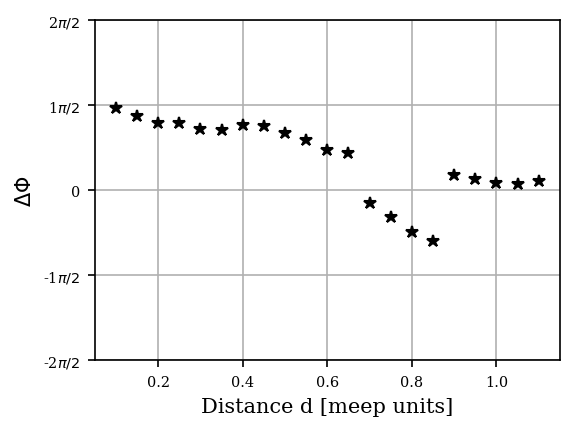

In [12]:


plt.plot(distances, Delta_Phi_list, "k*")

plt.xlabel(r"Distance d [meep units]")
plt.ylabel(r"$\Delta \Phi$")

ax = plt.gca()
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=np.pi/2))
ax.yaxis.set_major_formatter(FuncFormatter(
   lambda val,pos: '{:.0g}$\pi/2$'.format(val/(np.pi/2)) if val !=0 else '0'
))
plt.ylim(-np.pi,np.pi)

plt.grid()